The goal of this notebook is to prepare all the analytics that will support my "Quantifying Crowd Psychology (Pt. 1)" article. 

The full methodology of my approach can be read in markdown cells accompanying the code below.

In order to run this notebook, please make sure that your version of this notebook can access the `Robinhood_Master_v1.csv`, `df_apple_final.csv` and `custom_functions.py` files (these can all be found on this notebook's corresponding [Kaggle](https://www.kaggle.com/lechterventures/robinhood-user-participation-in-last-year). These are referenced in cells 4, 20 and 1 below, respectively. You can understand how the code interacts with these files by reviewing those cells.

If you have any questions/feedback/concerns, please don't hesitate to share them with me at adrian@lechterventures.com.

---
### Library and Data Import

Please make sure to set one of these booleans to True and another to False. The faster run happens when `is_fast_run` is set to True while `is_first_master_dataframe` is set to False.

In [1]:
#Skip to first master dataframe prior to data formatting/cleanup? Then keep this set to TRUE
is_first_master_dataframe = True

#Skip to final dataframe used in modeling? Then keep this set to TRUE. If you change this to FALSE,
#you must set the other boolean to True for the notebook to run
is_fast_run = False 

In [2]:
#Import libs
import ffn as f
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import display, Image
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from datetime import timedelta, datetime
import pandas_datareader as pdr
from os import listdir
from os.path import isfile, join
import os
import json
import shutil
import pytz
import matplotlib.dates as mdates
import urllib.request
import time
import plotly.express as px
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
from plotly.subplots import make_subplots
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation, performance_metrics
from pandasql import sqldf
import warnings

#import custom functions from main file - 
os.chdir('/directory/where/you/can/access/custom_functions')
import custom_functions as cp
os.chdir('/directory/that/was/toggled/before')

#realtime stock apis
from wallstreet import Stock, Call, Put

#hack used to access yahoo finance data for pandas data manipulation
yf.pdr_override()

#Activating pandasql to run queries
pysqldf = lambda q: sqldf(q, globals())

#Display visuals in notebook
%matplotlib inline
init_notebook_mode(connected = True) #to display plotly visuals
warnings.filterwarnings('ignore') #ignore warning flags on code cells

#Quick logic to ensure that booleans in cell 1 are toggled correctly
if not is_fast_run and not is_first_master_dataframe:
    is_fast_run = True #Default to fast run if you submitted both booleans as False

elif is_fast_run and is_first_master_dataframe:
    is_first_master_dataframe = False #Default to fast run if you submitted both booleans as True

elif is_first_master_dataframe:
    is_fast_run = False
    
elif is_fast_run:
    is_first_master_dataframe = False

In the following cell, I iterate all my stock and robinhood files to create one massive dataset combining all tickers.

In [3]:
if 1==2: #Dont want anyone to run this code but want to show how I acquired the data
    
        master_columns = {'Ticker', 'Open', 'High', 'Low', 'Close', 'Vol', 'OpenInt',
           'Clean_Datetime', 'Clean_Datetime_PST', 'users_holding_max',
           'users_holding_min', 'users_holding_first', 'users_holding_last'}
        test_master_df = pd.DataFrame(columns= master_columns)
        dictionary_of_master_dfs = {}
        dictionary_of_rh_dfs = {}
        sample_list = ['spy','vxx','qqq','iwm'] #this will come from list comprehension of onlyfiles done above

        for stock in sample_list:

            #Ingest Spooq data
            dictionary_of_master_dfs[stock] = pd.read_csv(f'/directory/with/stock/info/{stock}.us.txt')

            #Rename columns
            new_columns = {'<TICKER>':'Ticker', '<PER>':'Per', '<DATE>':'Date','<TIME>':'Time',
                          '<OPEN>':'Open', '<HIGH>':'High', '<LOW>':'Low', '<CLOSE>':'Close',
                           '<VOL>':'Vol', '<OPENINT>':'OpenInt'}
            dictionary_of_master_dfs[stock].rename(columns=new_columns, inplace=True)

            # Converting columns to string for date formatting
            dictionary_of_master_dfs[stock]['Date'] = dictionary_of_master_dfs[stock]['Date'].astype('str')
            dictionary_of_master_dfs[stock]['Time'] = dictionary_of_master_dfs[stock]['Time'].astype('str')

            #Aggregate date and time data into single column
            dictionary_of_master_dfs[stock]['Clean_Date'] = [
                '-'.join([x,y,z]) for x, y, z in zip(dictionary_of_master_dfs[stock]['Date'].str[0:4], 
                                                     dictionary_of_master_dfs[stock]['Date'].str[4:6], 
                                                    dictionary_of_master_dfs[stock]['Date'].str[6:8])]
            dictionary_of_master_dfs[stock]['Clean_Time'] = [
                ':'.join([x,y,z]) for x, y, z in zip(dictionary_of_master_dfs[stock]['Time'].str[0:2], 
                                                     dictionary_of_master_dfs[stock]['Time'].str[2:4],
                                                  dictionary_of_master_dfs[stock]['Time'].str[4:6])]

            #Create datetime column and set it to datetime data type with CET timezone
            dictionary_of_master_dfs[stock]['Clean_Datetime'] = [
                ' '.join([x,y]) for x, y in zip(dictionary_of_master_dfs[stock]['Clean_Date'], 
                                                dictionary_of_master_dfs[stock]['Clean_Time'])]

            dictionary_of_master_dfs[stock]['Clean_Datetime'] =\
                pd.DataFrame([cet.localize(x) for x in pd.to_datetime(dictionary_of_master_dfs[stock]['Clean_Datetime'])])

            #Clean ticket column so theres no '.US'
            dictionary_of_master_dfs[stock]['Ticker'] = dictionary_of_master_dfs[stock]['Ticker'].str.split('.').str[0]

            #Format datetime columns in Spooq/Robinhood and set to PST
            dictionary_of_master_dfs[stock]['Clean_Datetime_PST'] =\
                pd.DataFrame([x.astimezone(pst).\
                              strftime("%Y-%m-%d %H:%M:%S") for x in dictionary_of_master_dfs[stock]['Clean_Datetime']])
            dictionary_of_master_dfs[stock]['Clean_Datetime_PST'] =\
                pd.to_datetime(dictionary_of_master_dfs[stock]['Clean_Datetime_PST'])

            #Drop columns you wont need in analysis
            dictionary_of_master_dfs[stock] =\
                dictionary_of_master_dfs[stock].drop(['Per','Date','Date','Time','Clean_Date', 
                                               'Clean_Time', 'Clean_Datetime'], axis=1)
            #Ingest robinhood data
            dictionary_of_rh_dfs[stock] =\
                pd.read_csv(f'/directory/with/robinhood/info/{stock}.us.txt')

            #Convert robinhood timestamp data from string to PST-based timezone
            dictionary_of_rh_dfs[stock]['timestamp'] =\
                pd.DataFrame([utc.localize(x) for x in pd.to_datetime(dictionary_of_rh_dfs[stock]['timestamp'])])    
            dictionary_of_rh_dfs[stock]['Clean_Datetime_PST'] =\
                pd.DataFrame([x.astimezone(pst).\
                              strftime("%Y-%m-%d %H:%M:%S") for x in dictionary_of_rh_dfs[stock]['timestamp']])
            dictionary_of_rh_dfs[stock]['Clean_Datetime_PST'] =\
                pd.to_datetime(dictionary_of_rh_dfs[stock]['Clean_Datetime_PST'])

            #Need to bring datetimes to index for time aggregation
            dictionary_of_rh_dfs[stock].index = dictionary_of_rh_dfs[stock]['Clean_Datetime_PST'] 

            #Creating initial aggregation object to get OHLC for Robinhood users
            grouped = dictionary_of_rh_dfs[stock].resample('H')

            #Calculating OHLC aggregations
            max = grouped['users_holding'].max()
            min = grouped['users_holding'].min()
            first = grouped['users_holding'].first()
            last = grouped['users_holding'].last()

            rh_ohlc = pd.DataFrame({'users_holding_max':max, 'users_holding_min':min, 
                                         'users_holding_first':first, 'users_holding_last':last})

            rh_ohlc.reset_index(inplace=True)

            dictionary_of_master_dfs[stock] = pd.merge(dictionary_of_master_dfs[stock],rh_ohlc, on = 'Clean_Datetime_PST', how = 'left')

            display(f'{stock} dataframe')
            display(dictionary_of_master_dfs[stock].head())
            display(dictionary_of_master_dfs[stock].info())
            test_master_df = test_master_df.append(dictionary_of_master_dfs[stock])

        display(test_master_df.head())
        display(test_master_df.info())


else:
    pass
    

In [4]:
if is_first_master_dataframe:
    #Import Robinhood master, delete uncessary columns and explore components
    robinhood_master_df = pd.read_csv('Supplementary Files/Robinhood_Master_v1.csv')
    robinhood_master_df = robinhood_master_df.drop(columns= ['Unnamed: 0', 'Clean_Datetime'], axis = 1)
    display(robinhood_master_df.head())
    display(robinhood_master_df.info())
    
else:
    pass

Clean_Datetime_PST    Close     High      Low     Open  OpenInt Ticker  \
0  2019-09-23 08:00:00  51.8985  51.9595  51.8985  51.9595        0    IBA   
1  2019-09-23 10:00:00  51.9400  52.0300  51.9400  52.0300        0    IBA   
2  2019-09-23 11:00:00  51.9300  51.9300  51.9300  51.9300        0    IBA   
3  2019-09-23 12:00:00  52.3100  52.3100  51.8500  52.0571        0    IBA   
4  2019-09-23 13:00:00  52.2500  52.3000  52.2500  52.3000        0    IBA   

   Vol  users_holding_first  users_holding_last  users_holding_max  \
0  374                 22.0                22.0               22.0   
1  200                 22.0                22.0               22.0   
2  100                 22.0                22.0               22.0   
3  525                 22.0                22.0               22.0   
4  400                 22.0                22.0               22.0   

   users_holding_min  
0               22.0  
1               22.0  
2               22.0  
3               22.0  
4               22.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10419774 entries, 0 to 10419773
Data columns (total 12 columns):
Clean_Datetime_PST     object
Close                  float64
High                   float64
Low                    float64
Open                   float64
OpenInt                int64
Ticker                 object
Vol                    int64
users_holding_first    float64
users_holding_last     float64
users_holding_max      float64
users_holding_min      float64
dtypes: float64(8), int64(2), object(2)
memory usage: 954.0+ MB


None

Before diving into the questions, I want to get a better sense of the data I'm working with. For my next steps, I'm gonna get a couple high-level questions answered about this dataframe.

In [5]:
if is_first_master_dataframe:
    #How many tickers are represented in this dataset?
    total_tickers = np.count_nonzero(robinhood_master_df['Ticker'].unique())
    display(f'A total of {total_tickers} tickers are represented in this dataframe')

    #How far back does this data go?
    earliest_timestamp = robinhood_master_df['Clean_Datetime_PST'].min()
    display(f'The earlier timestamp in this dataframe is {earliest_timestamp}, so we have about a year of data to work with')

else:
    pass

'A total of 9067 tickers are represented in this dataframe'

'The earlier timestamp in this dataframe is 2019-09-23 07:00:00, so we have about a year of data to work with'

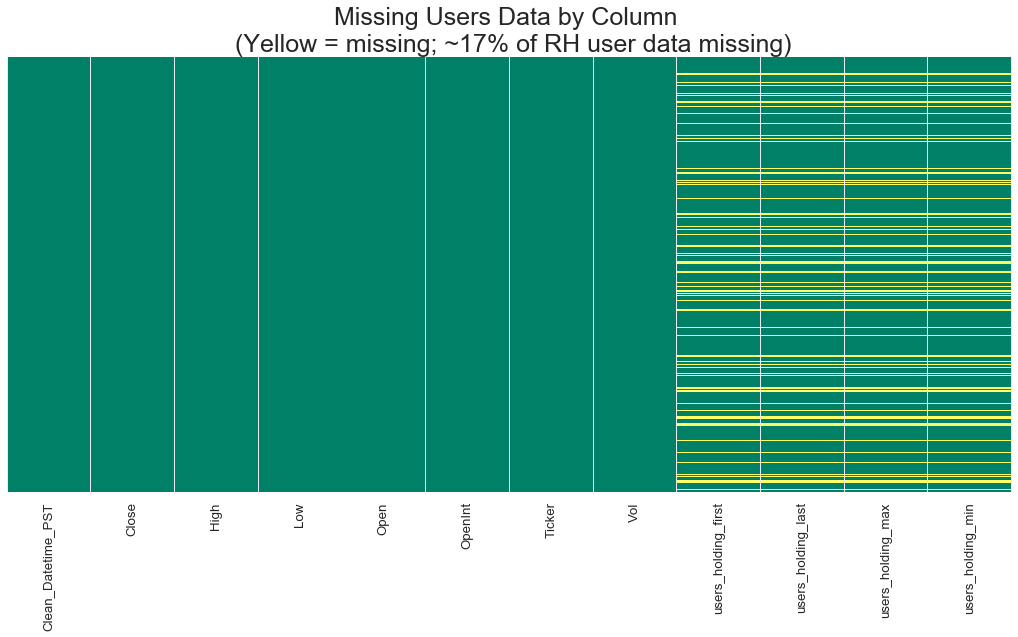

In [6]:
if is_first_master_dataframe:
    #What does our data missingness look like?
    sns.set_context('paper')
    plt.figure(figsize = (18,8))
    sns.set(font_scale=1.2)
    sns.heatmap(robinhood_master_df.isnull(),
                yticklabels = False, 
                cbar = False, cmap = 'summer').set_title('Missing Users Data by Column \n (Yellow = missing; ~17% of RH user data missing)', 
                                                         fontdict = {'fontsize': 25});
    
else:
    pass

We have about 10 million datapoints of hourly tick data and Robinhood user participation data going back almost a year. Of that data, we're missing about 17% of Robinhood transaction details, so we should exercise caution in whatever conclusions are drawn from it. Armed with this information let's actually begin thinking about the explorations we can do and questions we can answer.

### Key Questions

These are bulleted below for simplicity. There are more questions I wanted to explore, but this exercise alone took me quite a long time to prepare.

- If we plot a couple well-known stocks and look at the time series, are there any patterns that emerge?
- Just from looking at the stock price and robinhood data, can we play around with the data to see if there are indicators?

We'll begin with our first question. To begin getting a _'feel'_ for the data, we should look at the most popular tickers (ETF indices and some well-known names like Amazon, Apple) in addition to some popular commodities tickers.

In [7]:
if is_first_master_dataframe:
    #Drop rows missing robinhood transaction data
    robinhood_master_df_grapher = robinhood_master_df[robinhood_master_df['users_holding_first'].notna()]

    #Choose stocks to graphs and instantiate dataframe dictionaries (for graphing)
    stocks_to_study = ['SPY', 'QQQ', 'IWM', 'AMZN', 'AAPL', 'EXPE', 'USO', 'GLD', 'VXX']
    stock_df_dict = {}
    rh_df_dict = {}

    #Iterate through each stock an prepare the price-action vs Robinhood user participation graphs
    for ticker in stocks_to_study:

        #Get data for a single ticker
        stock_df_dict[ticker] = robinhood_master_df_grapher[robinhood_master_df_grapher['Ticker'] == ticker]
        tick_columns = ['Clean_Datetime_PST', 'Open']
        rh_columns = ['Clean_Datetime_PST', 'users_holding_first']
        rh_df_dict[ticker] = stock_df_dict[ticker][rh_columns]
        stock_df_dict[ticker] = stock_df_dict[ticker][tick_columns]
        stock_df_dict[ticker].rename(columns= {'Open':'Value'}, inplace=True)
        stock_df_dict[ticker]['Hue'] = 'Tick_Data'

        #RH data
        rh_df_dict[ticker].rename(columns= {'users_holding_first':'Value'}, inplace=True)
        rh_df_dict[ticker]['Hue'] = 'RH_Data'

        #Display data in overlayed time series
        display(cp.robinhood_stock_graph_overlay(stock_df_dict[ticker]['Clean_Datetime_PST'], 
                                  rh_df_dict[ticker]['Clean_Datetime_PST'],
                                  stock_df_dict[ticker]['Value'],
                                  rh_df_dict[ticker]['Value'], ticker))

else:
    pass

None

None

None

None

None

None

None

None

None

Fascinating. To keep things simple, I'll also bullet observations below:
- Most of the household tickers (whether you look at well-known indices like SPY/QQQ or individual stocks like AMZN and AAPL) **all have shown a strong retail participation uptrend following the post-COVID rally** beginning in March 2020. If we are trying to study RH user participation data as a possible indicator for future price action, we will need to adjust for user participation trends exhibited in the popular index ETF's. Given that these tickers play a pronounced role on price action for single stocks, it'll be important to _'tease out'_ the excess/deficient RH participation trends for single names relative to the larger indices. 


- Whether looking at a ticker like EXPE that has traded down following the onset of COVID or another like USO which also took a hit, they both also show increased amount of Robinhood user participation in recent months. It may very well be the case that every single stock has seen an uptrend in user particiption during this time. This makes sense anecdotally given most sporting events are cancelled, gyms are closed and folks are holed up in their homes looking for something to do.


- It's unfortunate this dataset does not show Robinhood user participation data for VXX but whatevs. It's also a little frustrating because you can see in the robintrack website that this data exists.

-----

Now that we've quickly skimmed a couple historical graphs, we should start trying to identify potential indicators from our existing datapoints. I now will aim to answer the following question:
- Does uptrending Robinhood user participation indicate a future rise in prices? And given the role passive index funds have in moving asset prices, does this trend still hold factoring in price and Robinhood user trends for tickers like SPY and QQQ?

We'll need to perform some feature engineering to arrive at the actual insights.

_(For personal reference or for technical stakeholders interested in my work)_

I make the following feature engineering changes to my data below:
- I aggregate all of my data into daily bins and perform Stock + Robinhood OHLC summary stats
- Calculate 1/6/13D stock % change and Robinhood user participation % change (the later intervals were 7/14 before, but I had to remove the data collected on dates where I am trying to predict a stock price. If I don't do this then I am basically cheating with this assignment.
- Calculate these stats for SPY and merge that data back to master dataframe to perform net % change calculations

In [8]:
if is_first_master_dataframe:
    #Need to bring datetimes to index for time aggregation
    robinhood_master_df_grapher.index = pd.to_datetime(robinhood_master_df_grapher['Clean_Datetime_PST'] )

    #Calculating OHLC aggregations
    stock_open = pd.DataFrame(robinhood_master_df_grapher.groupby([pd.Grouper(freq='D'), 'Ticker'])['Open'].first())
    stock_open.reset_index(inplace=True)

    stock_high = pd.DataFrame(robinhood_master_df_grapher.groupby([pd.Grouper(freq='D'), 'Ticker'])['High'].max())
    stock_high.reset_index(inplace=True)

    stock_low = pd.DataFrame(robinhood_master_df_grapher.groupby([pd.Grouper(freq='D'), 'Ticker'])['Low'].min())
    stock_low.reset_index(inplace=True)

    stock_close = pd.DataFrame(robinhood_master_df_grapher.groupby([pd.Grouper(freq='D'), 'Ticker'])['Close'].last())
    stock_close.reset_index(inplace=True)

    rh_open = pd.DataFrame(robinhood_master_df_grapher.groupby([pd.Grouper(freq='D'), 
                                                                'Ticker'])['users_holding_first'].first())
    rh_open.reset_index(inplace=True)

    rh_high = pd.DataFrame(robinhood_master_df_grapher.groupby([pd.Grouper(freq='D'), 
                                                          'Ticker'])['users_holding_max'].max())
    rh_high.reset_index(inplace=True)

    rh_low = pd.DataFrame(robinhood_master_df_grapher.groupby([pd.Grouper(freq='D'), 
                                                          'Ticker'])['users_holding_min'].min())
    rh_low.reset_index(inplace=True)

    rh_close = pd.DataFrame(robinhood_master_df_grapher.groupby([pd.Grouper(freq='D'), 
                                                          'Ticker'])['users_holding_last'].last())
    rh_close.reset_index(inplace=True)

    stock_volume = pd.DataFrame(robinhood_master_df_grapher.groupby([pd.Grouper(freq='D'), 'Ticker'])['Vol'].sum())
    stock_volume.reset_index(inplace=True)

    stock_open_interest = pd.DataFrame(robinhood_master_df_grapher.groupby([pd.Grouper(freq='D'), 'Ticker'])['OpenInt'].sum())
    stock_open_interest.reset_index(inplace=True)

    robinhood_master_df_grapher_daily = stock_open.merge(stock_high, on = ['Clean_Datetime_PST', 'Ticker']).\
                                                   merge(stock_low, on = ['Clean_Datetime_PST', 'Ticker']).\
                                                   merge(stock_close, on = ['Clean_Datetime_PST', 'Ticker']).\
                                                   merge(rh_open, on = ['Clean_Datetime_PST', 'Ticker']).\
                                                   merge(rh_high, on = ['Clean_Datetime_PST', 'Ticker']).\
                                                   merge(rh_low, on = ['Clean_Datetime_PST', 'Ticker']).\
                                                   merge(rh_close, on = ['Clean_Datetime_PST', 'Ticker']).\
                                                   merge(stock_volume, on = ['Clean_Datetime_PST', 'Ticker']).\
                                                   merge(stock_open_interest, on = ['Clean_Datetime_PST', 'Ticker'])

    # robinhood_master_df_grapher_daily.head()

    robinhood_master_df_grapher_daily_grouped_users_holding_open =\
        pd.DataFrame(robinhood_master_df_grapher_daily.groupby(['Clean_Datetime_PST', 'Ticker']).sum()['users_holding_first'])
    robinhood_master_df_grapher_daily_grouped_users_holding_open.reset_index(inplace=True)

    robinhood_master_df_grapher_daily_grouped_users_holding_open['users_holding 1D Back'] =\
        robinhood_master_df_grapher_daily_grouped_users_holding_open.groupby(['Ticker'])['users_holding_first'].shift(1)
    
    robinhood_master_df_grapher_daily_grouped_users_holding_open['users_holding 2D Back'] =\
        robinhood_master_df_grapher_daily_grouped_users_holding_open.groupby(['Ticker'])['users_holding_first'].shift(2)

    robinhood_master_df_grapher_daily_grouped_users_holding_open['users_holding 7D Back'] =\
        robinhood_master_df_grapher_daily_grouped_users_holding_open.groupby(['Ticker'])['users_holding_first'].shift(7)

    robinhood_master_df_grapher_daily_grouped_users_holding_open['users_holding 14D Back'] =\
        robinhood_master_df_grapher_daily_grouped_users_holding_open.groupby(['Ticker'])['users_holding_first'].shift(14)

    # display(robinhood_master_df_grapher_daily_grouped_users_holding_open[robinhood_master_df_grapher_daily_grouped_users_holding_open['Ticker'] == 'AAPL'].head(15))

    robinhood_master_df_grapher_daily_grouped_open =\
        pd.DataFrame(robinhood_master_df_grapher_daily.groupby(['Clean_Datetime_PST', 'Ticker']).sum()['Open'])
    robinhood_master_df_grapher_daily_grouped_open.reset_index(inplace=True)

    robinhood_master_df_grapher_daily_grouped_open['Open 1D Back'] =\
        robinhood_master_df_grapher_daily_grouped_open.groupby(['Ticker'])['Open'].shift(1)

    robinhood_master_df_grapher_daily_grouped_open['Open 2D Back'] =\
        robinhood_master_df_grapher_daily_grouped_open.groupby(['Ticker'])['Open'].shift(2)

    robinhood_master_df_grapher_daily_grouped_open['Open 7D Back'] =\
        robinhood_master_df_grapher_daily_grouped_open.groupby(['Ticker'])['Open'].shift(7)

    robinhood_master_df_grapher_daily_grouped_open['Open 14D Back'] =\
        robinhood_master_df_grapher_daily_grouped_open.groupby(['Ticker'])['Open'].shift(14)

    # display(robinhood_master_df_grapher_daily_grouped_open[robinhood_master_df_grapher_daily_grouped_open['Ticker'] == 'AAPL'].head(15))

    #Extract only new features we care about from these dataframes
    robinhood_master_df_grapher_daily_grouped_users_holding_open =\
        robinhood_master_df_grapher_daily_grouped_users_holding_open[['Clean_Datetime_PST', 'Ticker', 
                                                                      'users_holding 1D Back', 
                                                                      'users_holding 2D Back',
                                                                      'users_holding 7D Back', 
                                                                      'users_holding 14D Back']]

    robinhood_master_df_grapher_daily_grouped_open =\
        robinhood_master_df_grapher_daily_grouped_open[['Clean_Datetime_PST', 'Ticker', 
                                                                      'Open 1D Back', 
                                                                      'Open 2D Back', 
                                                                      'Open 7D Back', 
                                                                      'Open 14D Back']]

    #Merge them to main dataframe
    robinhood_master_df_grapher_daily = robinhood_master_df_grapher_daily.\
                                       merge(robinhood_master_df_grapher_daily_grouped_users_holding_open, on = ['Clean_Datetime_PST', 'Ticker']).\
                                       merge(robinhood_master_df_grapher_daily_grouped_open, on = ['Clean_Datetime_PST', 'Ticker'])

    #Double check everything was merged correctly through only looking at Apple data
    # robinhood_master_df_grapher_daily[robinhood_master_df_grapher_daily['Ticker'] == 'AAPL'].head(20)

    #Adding 1/6/13D change variables
    robinhood_master_df_grapher_daily['users_holding_1D_change'] =\
        round((robinhood_master_df_grapher_daily['users_holding 1D Back'] - robinhood_master_df_grapher_daily['users_holding 2D Back'])/robinhood_master_df_grapher_daily['users_holding 2D Back'],3)
    robinhood_master_df_grapher_daily['users_holding_6D_change'] =\
        round((robinhood_master_df_grapher_daily['users_holding 1D Back'] - robinhood_master_df_grapher_daily['users_holding 7D Back'])/robinhood_master_df_grapher_daily['users_holding 7D Back'],3)
    robinhood_master_df_grapher_daily['users_holding_13D_change'] =\
        round((robinhood_master_df_grapher_daily['users_holding 1D Back'] - robinhood_master_df_grapher_daily['users_holding 14D Back'])/robinhood_master_df_grapher_daily['users_holding 14D Back'],3)
    robinhood_master_df_grapher_daily['Open 1D_change'] =\
        round((robinhood_master_df_grapher_daily['Open 1D Back'] - robinhood_master_df_grapher_daily['Open 2D Back'])/robinhood_master_df_grapher_daily['Open 2D Back'],3)
    robinhood_master_df_grapher_daily['Open 6D_change'] =\
        round((robinhood_master_df_grapher_daily['Open 1D Back'] - robinhood_master_df_grapher_daily['Open 7D Back'])/robinhood_master_df_grapher_daily['Open 7D Back'],3)
    robinhood_master_df_grapher_daily['Open 13D_change'] =\
        round((robinhood_master_df_grapher_daily['Open 1D Back'] - robinhood_master_df_grapher_daily['Open 14D Back'])/robinhood_master_df_grapher_daily['Open 14D Back'],3)

    #Drop the other 1/7/14D columns that aren't needed with these changes made
    robinhood_master_df_grapher_daily =\
        robinhood_master_df_grapher_daily.drop(['users_holding 1D Back','users_holding 2D Back',
                                                'users_holding 7D Back','users_holding 14D Back',
                                                'Open 1D Back','Open 2D Back','Open 7D Back', 
                                                'Open 14D Back'], axis=1)

    #Create dataframe of just SPY data (to create SPY-specific features)
    robinhood_master_df_grapher_daily_spy = robinhood_master_df_grapher_daily[robinhood_master_df_grapher_daily['Ticker'] == 'SPY']

    #Only leave key columns you'll need for join
    columns = ['Clean_Datetime_PST', 'users_holding_1D_change', 'users_holding_6D_change', 'users_holding_13D_change', 
               'Open 1D_change', 'Open 6D_change', 'Open 13D_change']
    robinhood_master_df_grapher_daily_spy = robinhood_master_df_grapher_daily_spy[columns]

    #Rename columns
    new_columns = {'users_holding_1D_change':'SPY users_holding_1D_change', 
                   'users_holding_6D_change':'SPY users_holding_6D_change', 
                   'users_holding_13D_change':'SPY users_holding_13D_change',
                   'Open 1D_change':'SPY Open 1D_change', 'Open 6D_change': 'SPY Open 6D_change',
                  'Open 13D_change':'SPY Open 13D_change'}
    robinhood_master_df_grapher_daily_spy.rename(columns=new_columns, inplace=True)
    # robinhood_master_df_grapher_daily_spy.head(20)

    #Merge dataframes
    robinhood_master_df_grapher_daily = pd.merge(robinhood_master_df_grapher_daily,
                                                 robinhood_master_df_grapher_daily_spy,
                                                 on='Clean_Datetime_PST')

    #Calculate net change columns
    robinhood_master_df_grapher_daily['Open 1D_change Net'] =\
        robinhood_master_df_grapher_daily['Open 1D_change'] - robinhood_master_df_grapher_daily['SPY Open 1D_change']
    robinhood_master_df_grapher_daily['Open 6D_change Net'] =\
        robinhood_master_df_grapher_daily['Open 6D_change'] - robinhood_master_df_grapher_daily['SPY Open 6D_change']
    robinhood_master_df_grapher_daily['Open 13D_change Net'] =\
        robinhood_master_df_grapher_daily['Open 13D_change'] - robinhood_master_df_grapher_daily['SPY Open 13D_change']
    robinhood_master_df_grapher_daily['users_holding_1D_change Net'] =\
        robinhood_master_df_grapher_daily['users_holding_1D_change'] - robinhood_master_df_grapher_daily['SPY users_holding_1D_change']
    robinhood_master_df_grapher_daily['users_holding_6D_change Net'] =\
        robinhood_master_df_grapher_daily['users_holding_6D_change'] - robinhood_master_df_grapher_daily['SPY users_holding_6D_change']
    robinhood_master_df_grapher_daily['users_holding_13D_change Net'] =\
        robinhood_master_df_grapher_daily['users_holding_13D_change'] - robinhood_master_df_grapher_daily['SPY users_holding_13D_change']
    

    #Preview master dataframe
    pd.set_option('display.max_columns', 30)
    display(robinhood_master_df_grapher_daily[robinhood_master_df_grapher_daily['Ticker'] == 'AAPL'].head(20))
    pd.set_option('display.max_columns', 20)
    
else:
    pass

Clean_Datetime_PST Ticker    Open    High     Low   Close  \
12             2019-09-23   AAPL  217.18  218.07  215.91  216.96   
6640           2019-09-24   AAPL  219.26  220.69  215.45  215.94   
13309          2019-09-25   AAPL  216.79  219.73  215.41  219.26   
19942          2019-09-26   AAPL  218.23  219.17  217.06  218.12   
26532          2019-09-27   AAPL  218.77  219.19  215.54  217.06   
33178          2019-09-30   AAPL  219.13  222.78  219.02  222.17   
39830          2019-10-01   AAPL  223.27  226.39  222.40  222.78   
46486          2019-10-02   AAPL  221.26  221.78  216.18  217.19   
53172          2019-10-03   AAPL  216.67  219.19  213.40  219.05   
59833          2019-10-04   AAPL  223.82  225.66  222.09  225.18   
66487          2019-10-07   AAPL  224.45  228.08  224.02  225.23   
73143          2019-10-08   AAPL  224.00  226.23  222.56  222.59   
79814          2019-10-09   AAPL  225.20  225.96  223.82  225.20   
86470          2019-10-10   AAPL  226.10  228.59  225.47  228.24   
93135          2019-10-11   AAPL  231.07  235.73  230.44  234.31   
99843          2019-10-14   AAPL  233.02  236.22  232.79  233.97   
106459         2019-10-15   AAPL  234.49  235.74  233.00  233.43   
113171         2019-10-16   AAPL  231.49  233.35  231.32  232.49   
119828         2019-10-17   AAPL  233.21  234.25  231.64  233.39   
126479         2019-10-18   AAPL  232.71  235.67  232.41  234.38   

        users_holding_first  users_holding_max  users_holding_min  \
12                 208615.0           208800.0           208615.0   
6640               208732.0           208732.0           208603.0   
13309              208476.0           208476.0           208035.0   
19942              207913.0           207913.0           207604.0   
26532              207527.0           207527.0           207424.0   
33178              207519.0           207524.0           207112.0   
39830              206822.0           206822.0           206388.0   
46486              206146.0           206403.0           206099.0   
53172              206404.0           206404.0           206221.0   
59833              205984.0           205984.0           205243.0   
66487              204867.0           204867.0           203777.0   
73143              203685.0           203685.0           203459.0   
79814              203495.0           203495.0           203334.0   
86470              203023.0           203023.0           202443.0   
93135              202357.0           202357.0           201842.0   
99843              201954.0           202295.0           201954.0   
106459             202308.0           202431.0           202308.0   
113171             202288.0           202288.0           202195.0   
119828             202179.0           202216.0           202161.0   
126479             202121.0           202121.0           201786.0   

        users_holding_last       Vol  OpenInt  users_holding_1D_change  \
12                208779.0  15151146        0                      NaN   
6640              208603.0  24344498        0                      NaN   
13309             208035.0  17166844        0                    0.001   
19942             207604.0  12894283        0                   -0.001   
26532             207444.0  18098687        0                   -0.003   
33178             207112.0  20742776        0                   -0.002   
39830             206388.0  26207882        0                   -0.000   
46486             206403.0  27414665        0                   -0.003   
53172             206221.0  21982124        0                   -0.003   
59833             205243.0  27882281        0                    0.001   
66487             203777.0  23733316        0                   -0.002   
73143             203459.0  19229850        0                   -0.005   
79814             203334.0  13684603        0                   -0.006   
86470             202443.0  22059852        0                   -0.001   
93135             

In order to determine how important the Robinhood data is, we'll build a forecast around this data. By building unique models that only incorporate 1 of the additional predictors, we can compare accuracy metrics across models to perform a feature importance analysis. We'll try this just with Apple stock for now.

In [9]:
if is_fast_run:
    pass

else:
    #Create dataframe
    df_apple_time_series = robinhood_master_df_grapher_daily[robinhood_master_df_grapher_daily['Ticker'] == 'AAPL']
    df_apple_time_series.reset_index(inplace=True)
    df_apple_time_series = df_apple_time_series.set_index('Clean_Datetime_PST')
    # df_apple_time_series = df_apple_time_series.drop(columns= ['index'], axis = 1)

    #Analyze components of dataframe
    display(df_apple_time_series.head())
    display(df_apple_time_series.info())

index Ticker    Open    High     Low   Close  \
Clean_Datetime_PST                                                 
2019-09-23             12   AAPL  217.18  218.07  215.91  216.96   
2019-09-24           6640   AAPL  219.26  220.69  215.45  215.94   
2019-09-25          13309   AAPL  216.79  219.73  215.41  219.26   
2019-09-26          19942   AAPL  218.23  219.17  217.06  218.12   
2019-09-27          26532   AAPL  218.77  219.19  215.54  217.06   

                    users_holding_first  users_holding_max  users_holding_min  \
Clean_Datetime_PST                                                              
2019-09-23                     208615.0           208800.0           208615.0   
2019-09-24                     208732.0           208732.0           208603.0   
2019-09-25                     208476.0           208476.0           208035.0   
2019-09-26                     207913.0           207913.0           207604.0   
2019-09-27                     207527.0           207527.0           207424.0   

                    users_holding_last  ...  SPY users_holding_13D_change  \
Clean_Datetime_PST                      ...                                 
2019-09-23                    208779.0  ...                           NaN   
2019-09-24                    208603.0  ...                           NaN   
2019-09-25                    208035.0  ...                           NaN   
2019-09-26                    207604.0  ...                           NaN   
2019-09-27                    207444.0  ...                           NaN   

                    SPY Open 1D_change  SPY Open 6D_change  \
Clean_Datetime_PST                                           
2019-09-23                         NaN                 NaN   
2019-09-24                         NaN                 NaN   
2019-09-25                       0.006                 NaN   
2019-09-26                      -0.012                 NaN   
2019-09-27                       0.006                 NaN   

                    SPY Open 13D_change  Open 1D_change Net  \
Clean_Datetime_PST                                            
2019-09-23                          NaN                 NaN   
2019-09-24                          NaN                 NaN   
2019-09-25                          NaN               0.004   
2019-09-26                          NaN               0.001   
2019-09-27                          NaN               0.001   

                    Open 6D_change Net  Open 13D_change Net  \
Clean_Datetime_PST                                            
2019-09-23                         NaN                  NaN   
2019-09-24                         NaN                  NaN   
2019-09-25                         NaN                  NaN   
2019-09-26                         NaN                  NaN   
2019-09-27                         NaN                  NaN   

                    users_holding_1D_change Net  users_holding_6D_change Net  \
Clean_Datetime_PST                                                             
2019-09-23                                  NaN                          NaN   
2019-09-24                                  NaN                          NaN   
2019-09-25                                0.000                          NaN   
2019-09-26                               -0.003                          NaN   
2019-09-27                               -0.004                          NaN   

                    users_holding_13D_change Net  
Clean_Datetime_PST                                
2019-09-23                                   NaN  
2019-09-24                                   NaN  
2019-09-25                                   NaN  
2019-09-26                                   NaN  
2019-09-27                                   NaN  

[5 rows x 30 columns]

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 199 entries, 2019-09-23 to 2020-07-17
Data columns (total 30 columns):
index                           199 non-null int64
Ticker                          199 non-null object
Open                            199 non-null float64
High                            199 non-null float64
Low                             199 non-null float64
Close                           199 non-null float64
users_holding_first             199 non-null float64
users_holding_max               199 non-null float64
users_holding_min               199 non-null float64
users_holding_last              199 non-null float64
Vol                             199 non-null int64
OpenInt                         199 non-null int64
users_holding_1D_change         197 non-null float64
users_holding_6D_change         192 non-null float64
users_holding_13D_change        185 non-null float64
Open 1D_change                  197 non-null float64
Open 6D_change                  192

None

There are a number of checks and additional feature engineering that may need to be performed here. These include:
- Removing rows with missing data
- Check for autocorrelation
- Check for stationarity and perform cleanup if not showing
- Remove predictors that are correlated with each other
- Determining the appropriate arguments for our time series model

Let's begin!

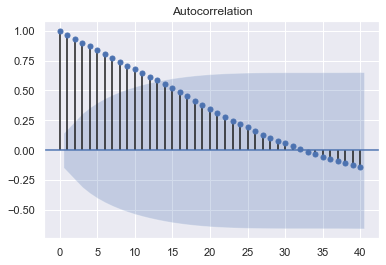

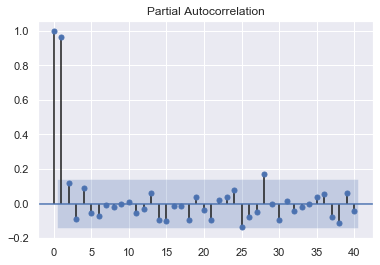

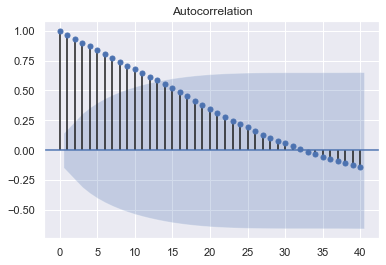

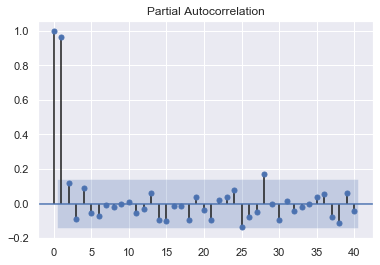

In [10]:
if is_fast_run:
    pass

else:
    #Make font size on graphs appropriate
    sns.set(font_scale=1)

    #Remove rows with missing data and make datetime index
    df_apple_time_series = df_apple_time_series.dropna()

    #Get target column to check for autocorrelation & stationarity
    df_apple_time_series_graph = df_apple_time_series['Open']

    # autocorrelation
    display(sm.graphics.tsa.plot_acf(df_apple_time_series_graph, lags=40))
    # partial autocorrelation
    display(sm.graphics.tsa.plot_pacf(df_apple_time_series_graph, lags=40))

We see that the time series exhibits autocorrelation throughout most of the data. And we see a significant correlation at lags 1-2 followed by insignificant correlations (when looking at the partial autocorrelation graph).

Text(0.5, 1.0, 'Apple Stock over last ~1Yr')

(-0.17982365810100157,
 0.9408842401648086,
 1,
 183,
 {'1%': -3.466598080268425,
  '5%': -2.8774669520682674,
  '10%': -2.5752604356654425},
 1179.5438548244629)

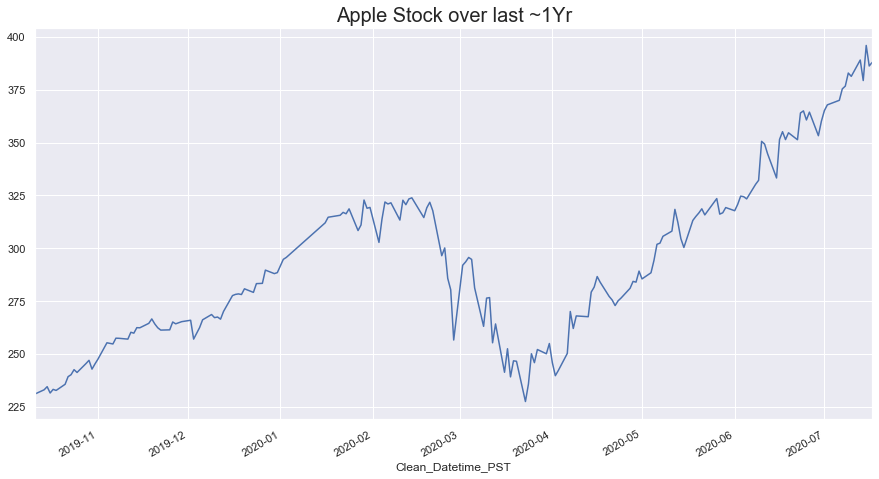

In [11]:
if is_fast_run:
    pass

else:
    #Plot the target variable with no adjustments to eyeball stationarity
    plt.figure(figsize = (15,8));
    display(df_apple_time_series_graph.plot().set_title('Apple Stock over last ~1Yr', fontdict = {'fontSize':20}));

    #Performing Dicky Fuller Test to validate stationarity
    results = adfuller(df_apple_time_series_graph)
    display(results)

Data is clearly not stationary, can the graph visualizes along with our small Dicky Fuller test value of -0.17. Let's take the 1D difference in open prices and see if that fixes it.

Target
Clean_Datetime_PST        
2020-07-10           -1.56
2020-07-13            7.72
2020-07-14           -9.70
2020-07-15           16.60
2020-07-16           -9.71

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 183 entries, 2019-10-14 to 2020-07-16
Data columns (total 1 columns):
Target    183 non-null float64
dtypes: float64(1)
memory usage: 2.9 KB


None

(-17.235024543105325,
 6.158204375248753e-30,
 0,
 182,
 {'1%': -3.4668001583460613,
  '5%': -2.8775552336674317,
  '10%': -2.5753075498128246},
 1165.64093938667)

<Figure size 1080x576 with 0 Axes>

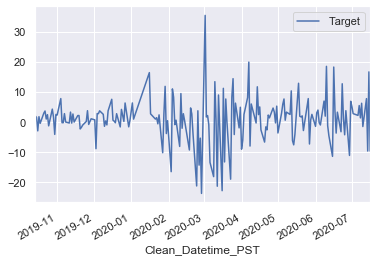

In [12]:
if is_fast_run:
    pass

else:
    #Take difference and plot to see if stationarity is fixed
    df_apple_stationary = pd.DataFrame(df_apple_time_series_graph.diff().dropna())
    # df_apple_stationary.reset_index(inplace=True)
    df_apple_stationary.drop(df_apple_stationary.tail(1).index,inplace=True)
    df_apple_stationary['Open'] = df_apple_stationary['Open'].astype(float)

    #Rename columns
    df_apple_stationary.rename(columns={'Open':'Target'}, inplace=True)
    display(df_apple_stationary.tail())
    display(df_apple_stationary.info())

    #Performing Dicky Fuller Test to validate stationarity
    results = adfuller(df_apple_stationary)
    display(results)

    #Plot graph
    plt.figure(figsize = (15,8));
    display(df_apple_stationary.plot());

The data is much better now - it looks stationary. Let's now begin checking correlations amongst predictors. I didn't include the following time series subplot below in my published article, but its a cool way to eyeball these correlations.

<Figure size 1080x576 with 0 Axes>

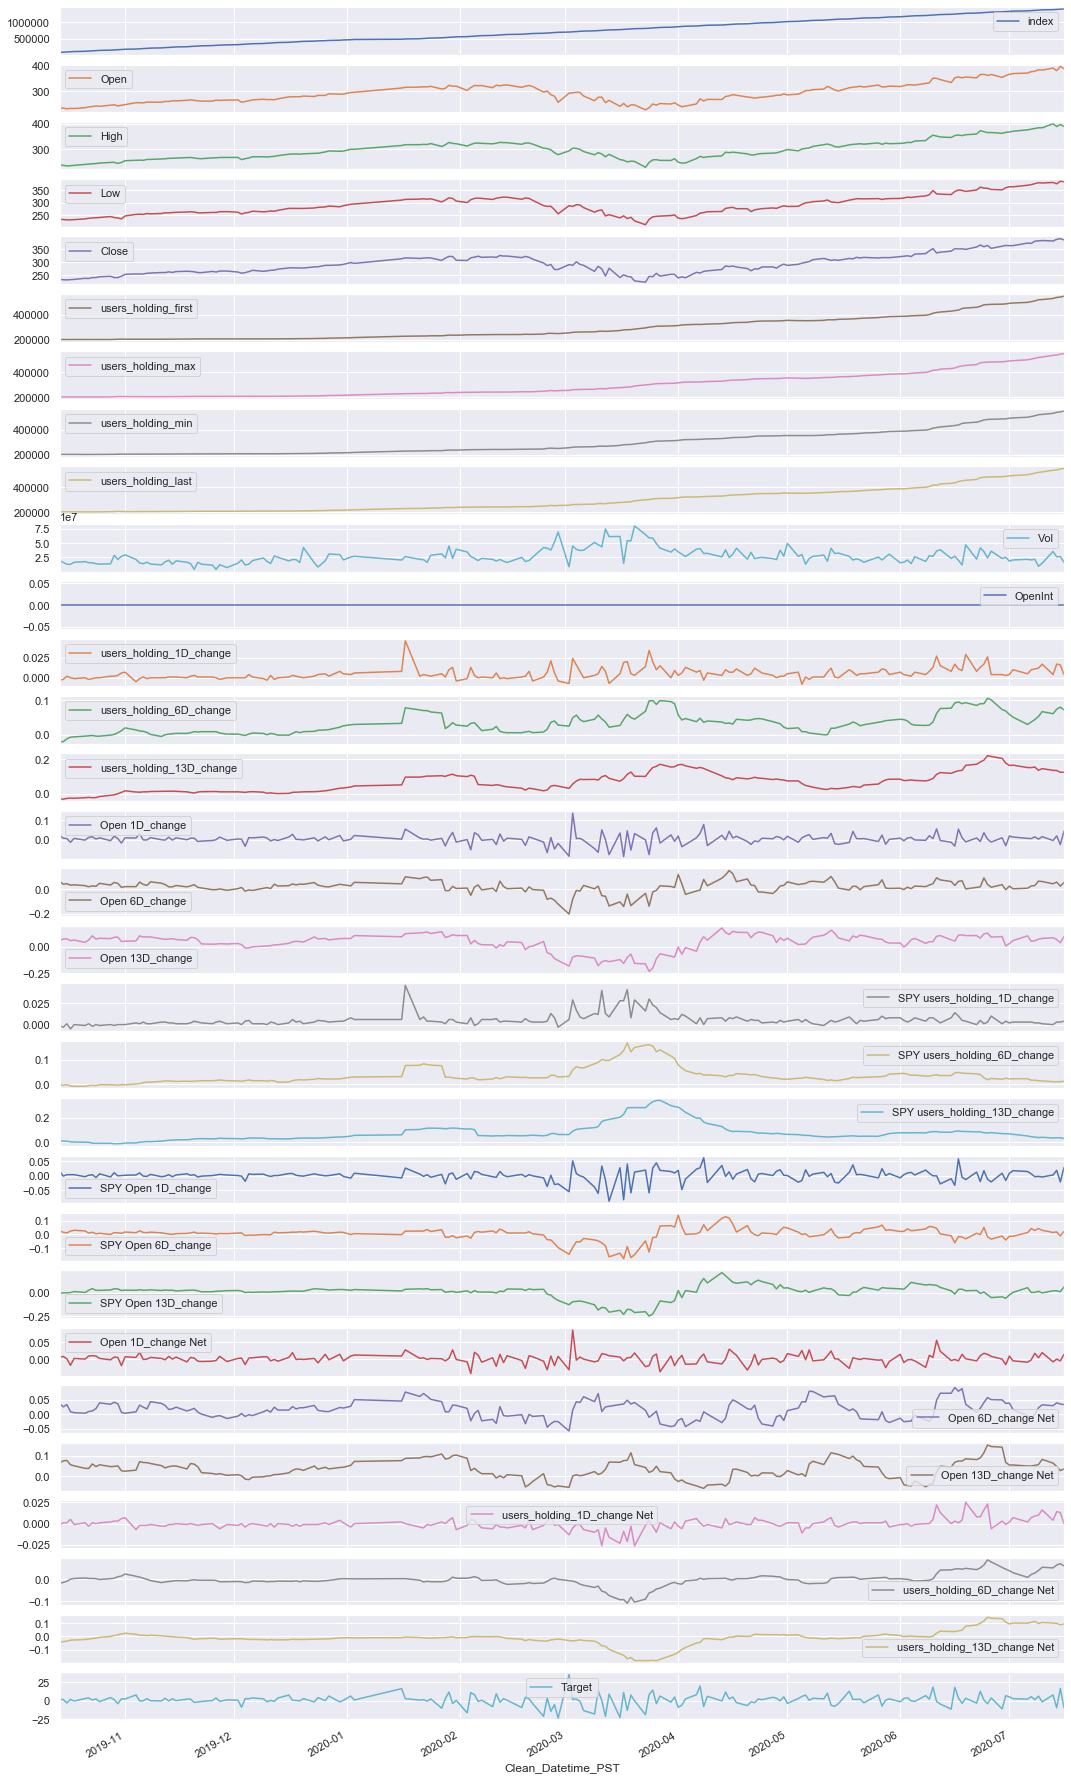

In [13]:
if is_fast_run:
    pass

else:
    #Making difference the target variable
    df_apple_time_series = df_apple_time_series.join(df_apple_stationary).dropna()
    # df_apple_time_series.head()

    plt.figure(figsize = (15,8));
    sns.set(font_scale=1)
    df_apple_time_series.plot(subplots = True, figsize = [18,35]);



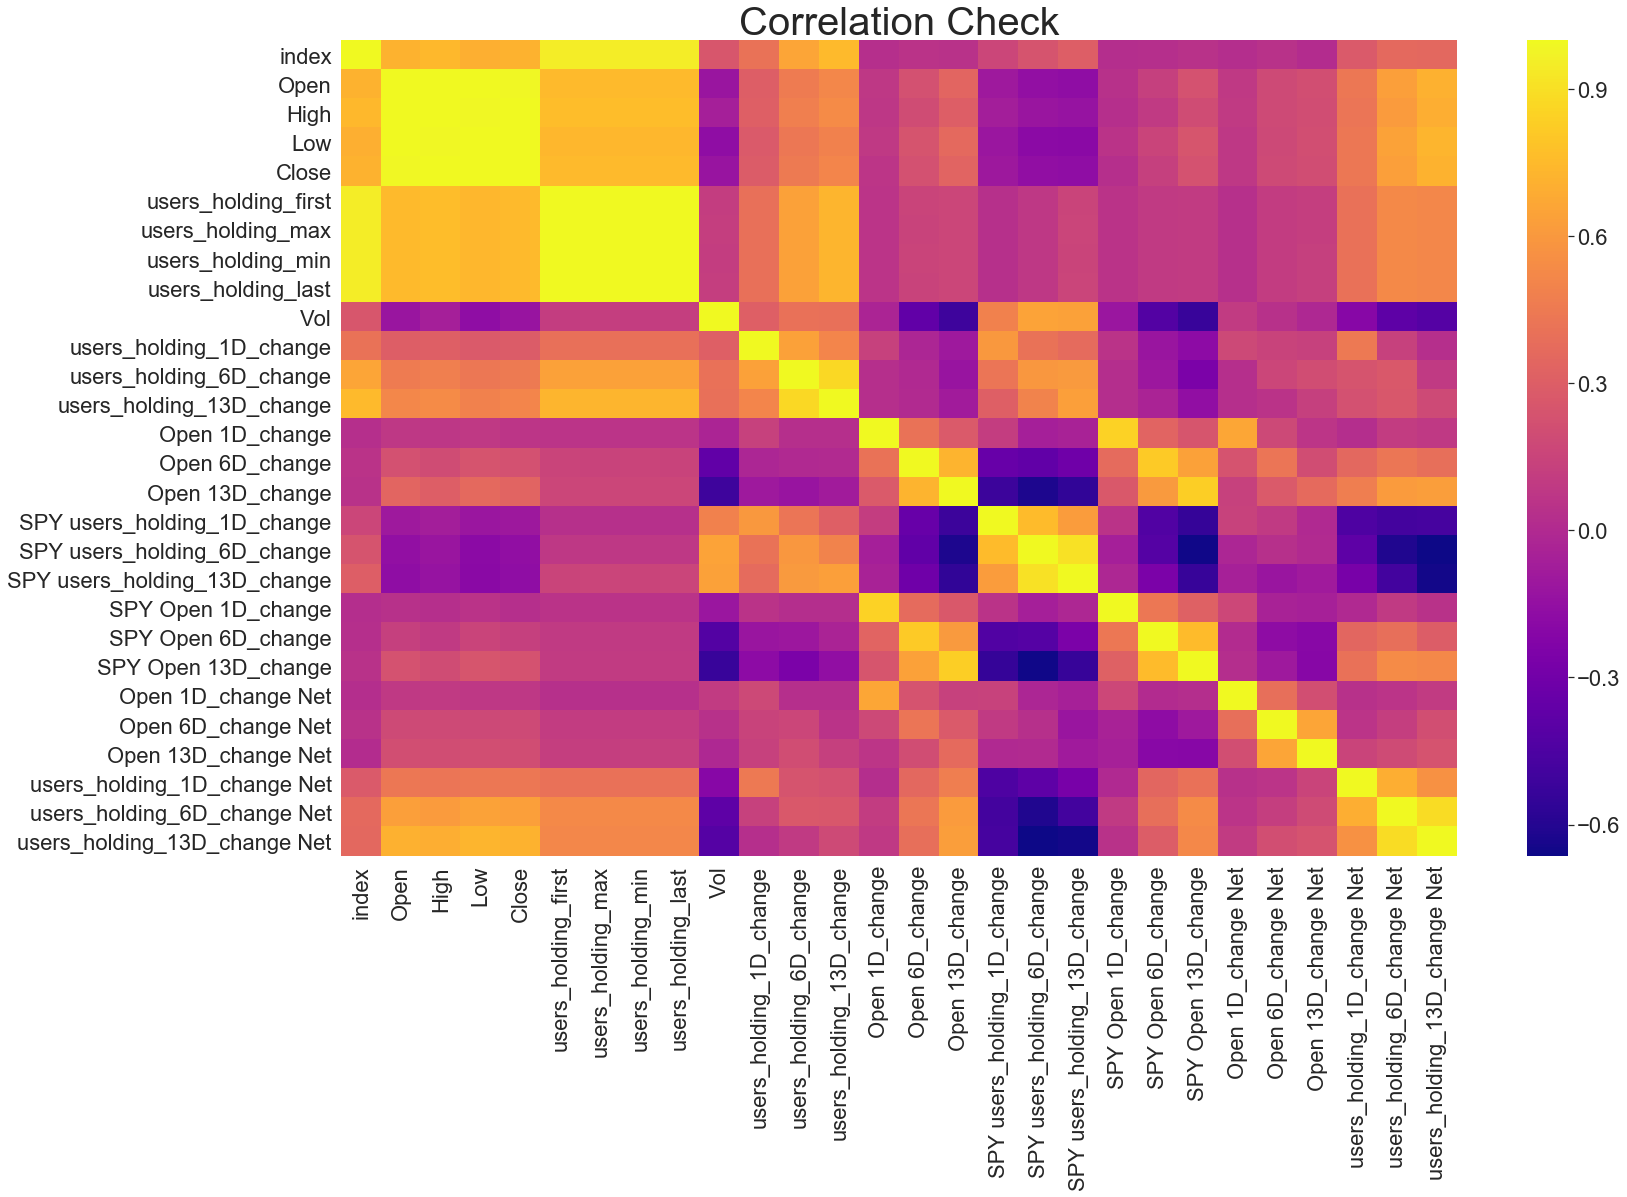

In [14]:
if is_fast_run:
    pass

else:
    #While above data viz looks cool, its not super useful.. going to plot correlation matrix instead
    #(We ignore OpenInt variable since its 0 throughout most of the dataset)
    sns.set_context('paper')
    plt.figure(figsize = (25,15))
    sns.set(font_scale=2)
    sns.heatmap(df_apple_time_series.drop(['Target', 'OpenInt'], axis = 1).corr(), 
                annot = False, cmap = 'plasma').set_title('Correlation Check', 
                                                          fontdict = {'fontsize':40})

We can now begin identifying predictors that are correlated with each other. Thoughts below:
- The correlation matrix identifies a couple buckets of predictors that are correlated with each other: OHLC values, user holding 6D/13D change data, Open 6/13D change data, all the SPY users holding change data, SPY 6/13D change data, open 6/13 net change data, and users holding 6/13D change net data.

As a result of this first pass, we'll remove the following predictors from our modeling dataset:
- OHLC except close
- all users holding columns except users_holding_first
- user holding 6D change
- open 1D change (this is the target column)
- SPY 6/13D users holding data
- SPY Open 6D change data
- open 13D net change data
- users holding 6D change net data

What does the correlation matrix look like now?

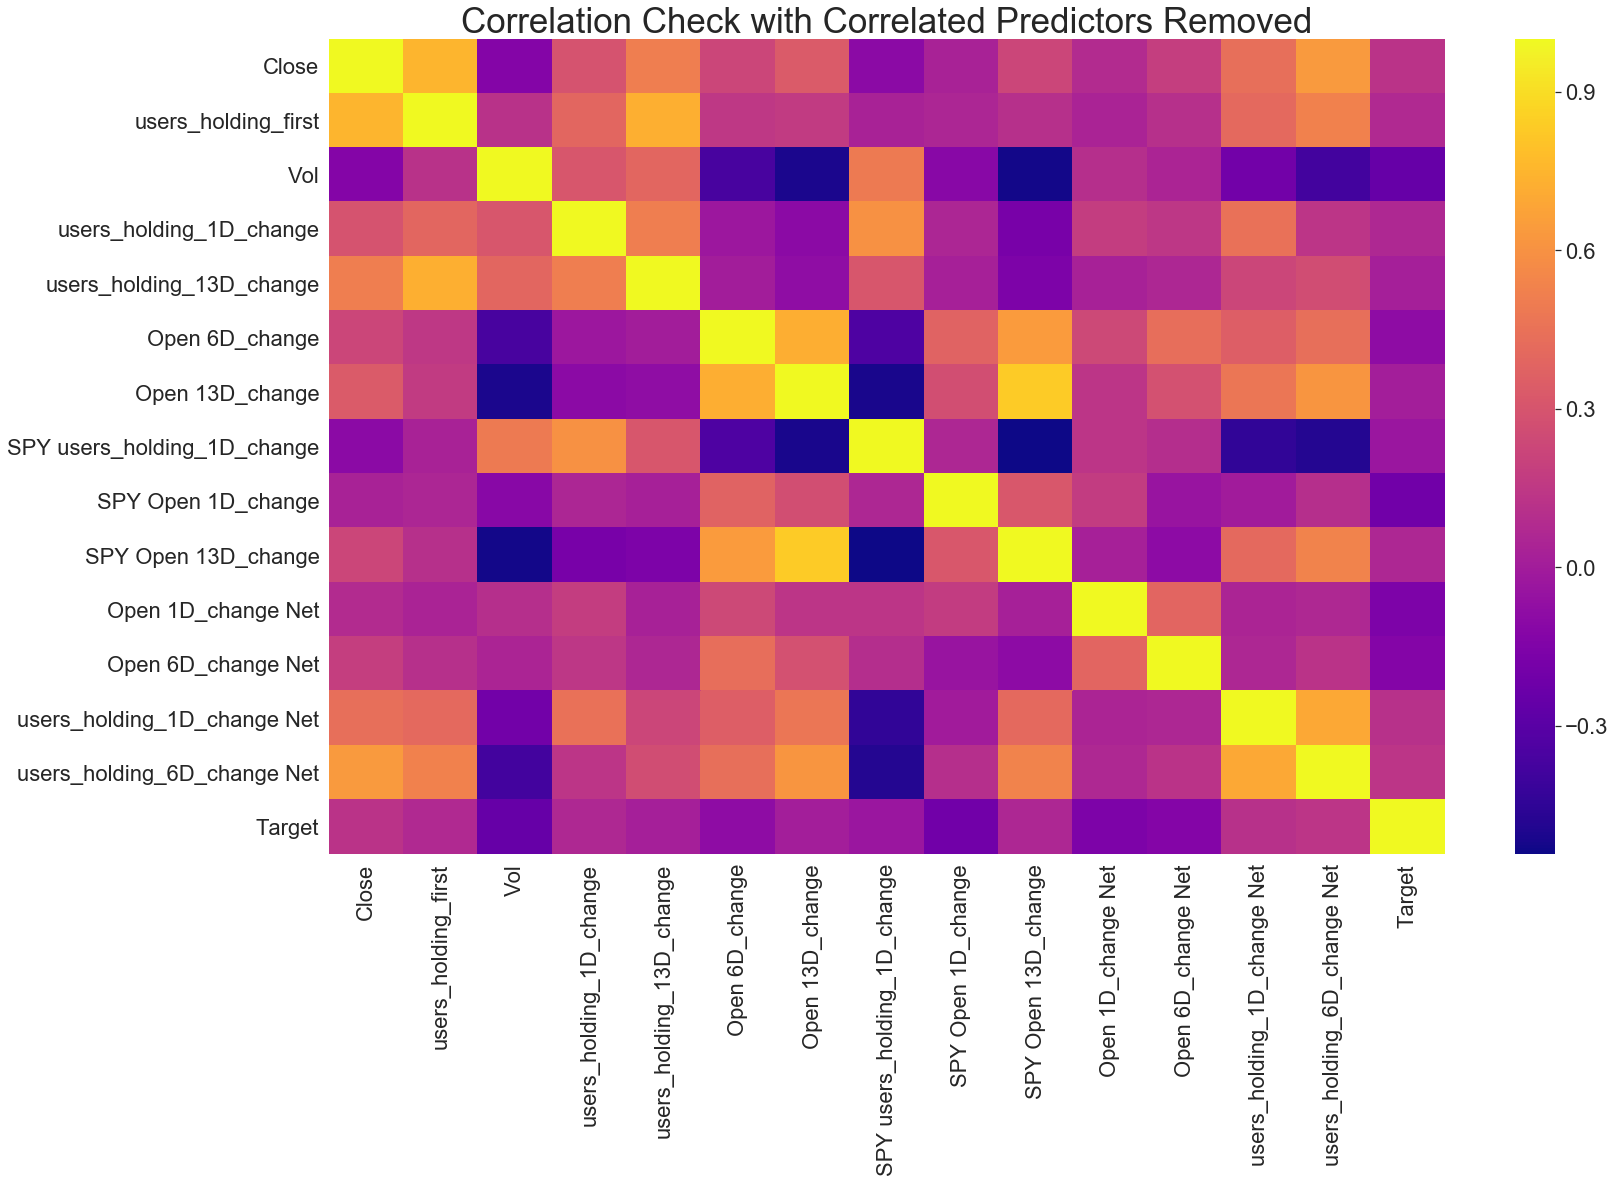

In [15]:
if is_fast_run:
    pass

else:
    #Drop correlated predictors
    columns = ['index', 'OpenInt', 'Open', 'High', 'Low', 'users_holding_max', 'users_holding_min', 
               'users_holding_last', 'users_holding_6D_change', 'Open 1D_change', 
               'SPY users_holding_6D_change', 'SPY users_holding_13D_change', 'SPY Open 6D_change', 
               'Open 13D_change Net', 'users_holding_13D_change Net']
    df_apple_time_series_with_dropped_predictors = df_apple_time_series.drop(columns, axis = 1)

    #Let's try viz v2
    sns.set_context('paper')
    plt.figure(figsize = (25,15))
    sns.set(font_scale=2)
    sns.heatmap(df_apple_time_series_with_dropped_predictors.corr(), 
                annot = False, cmap = 'plasma').set_title('Correlation Check with Correlated Predictors Removed', 
                                                          fontdict = {'fontsize':35})

We should drop `Close` since its value will always be calculated after `Open` (we cant use a predictor if its reported after the target variable). We'll also drop the `users_holding_1D_change Net` because of correlation amongst predictors.

Now how does our matrix look?

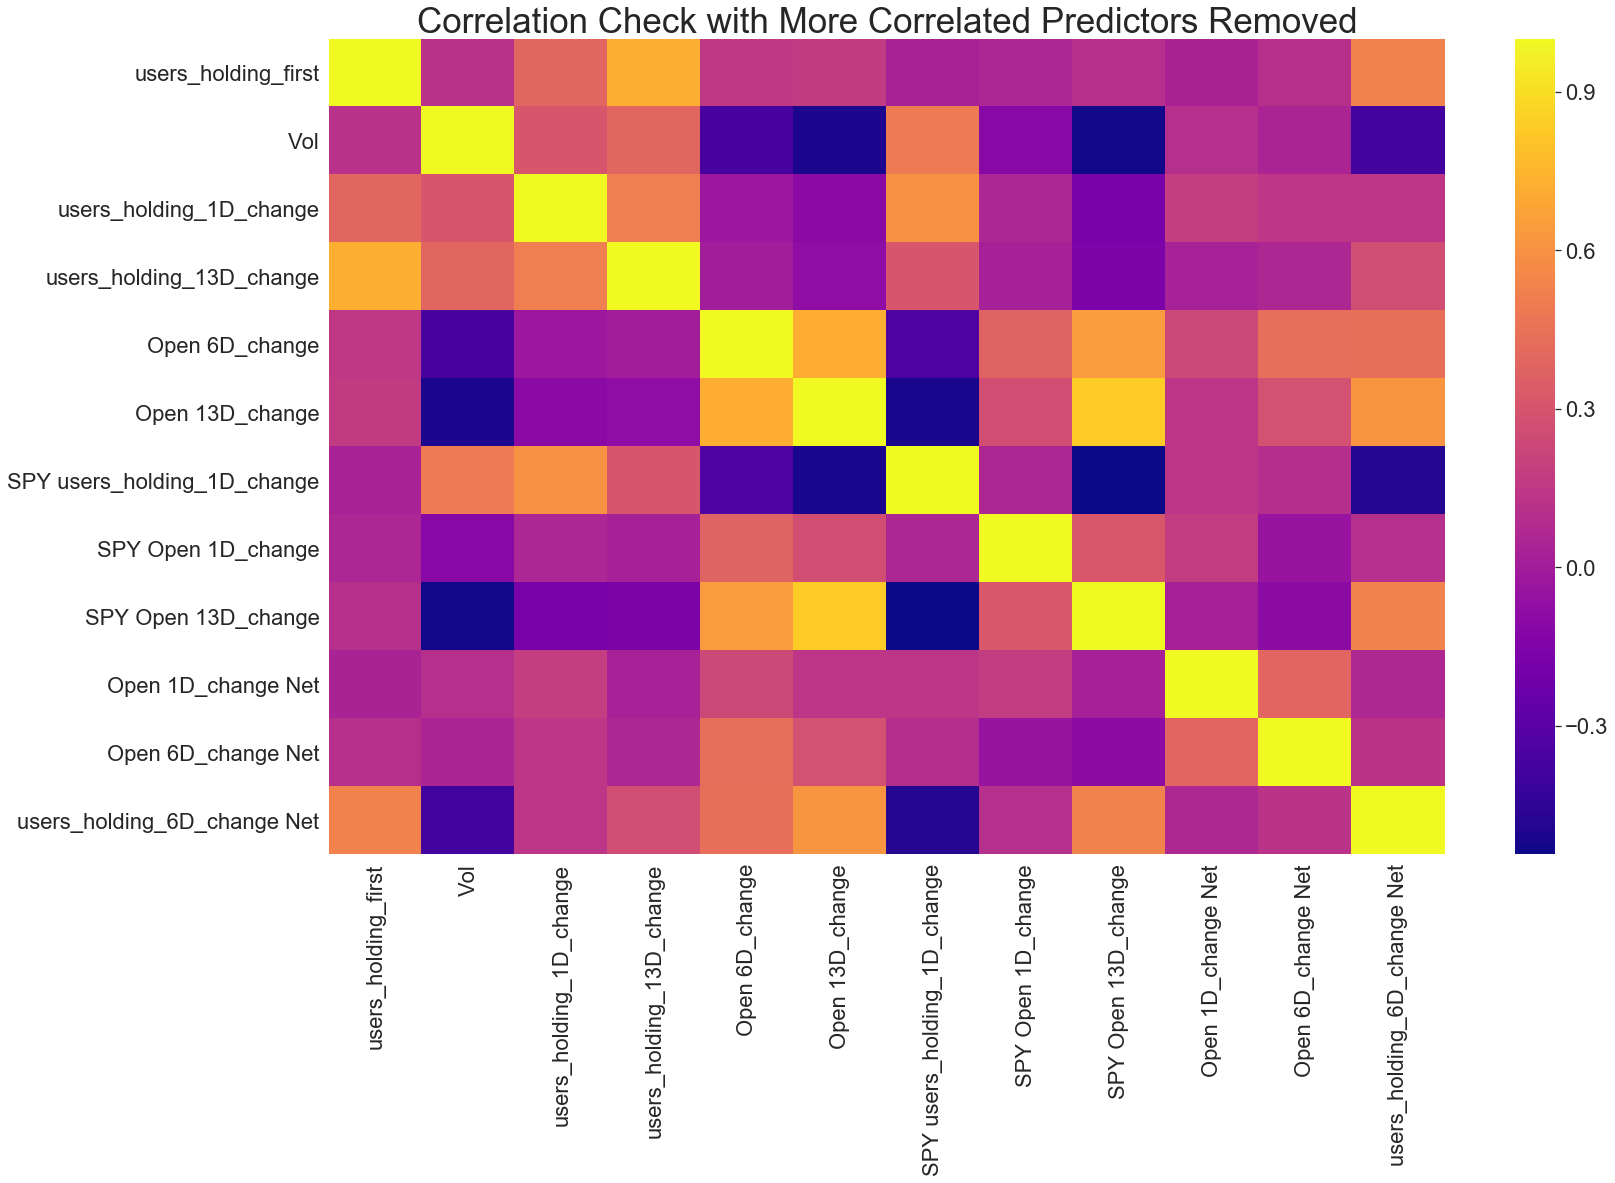

In [16]:
if is_fast_run:
    pass

else:
    #Drop more correlated predictors
    columns = ['Close', 'users_holding_1D_change Net', 'Ticker']
    df_apple_time_series_with_dropped_predictors =\
        df_apple_time_series_with_dropped_predictors.drop(columns, axis = 1)

    #Let's try viz v3
    sns.set_context('paper')
    plt.figure(figsize = (25,15))
    sns.set(font_scale=2)
    sns.heatmap(df_apple_time_series_with_dropped_predictors.drop(['Target'], axis = 1).corr(), 
                annot = False, cmap = 'plasma').set_title('Correlation Check with More Correlated Predictors Removed', 
                                                          fontdict = {'fontsize':35});

    #Reset font scale for future graphs
    sns.set(font_scale=1)

We've removed rows with missing data, checked for autocorrelation, feature engineered our target column to exhibit stationarity, and removed predictors from our dataset that are correlated with each other. 

Before creating our model, I realized we have 2 features we'll need to lag by one day: trading volume (`Vol`) and the column `users_holding_first`. This is because these features are calculated at the same time as the `Open` column, which is the original target variable we wanted to predict _(but we now have to look at Open 1 day price difference because of the stationarity assumption discussed above)_. I'm going to lag both of these columns by one day and re-run the correlation matrix to confirm the predictors do not exhibit correlation with each other.

In [17]:
#Volume and users_holding need to be lagged
df_apple_time_series_with_dropped_predictors['Vol_1D_Lag'] =\
    df_apple_time_series_with_dropped_predictors['Vol'].shift(1)
df_apple_time_series_with_dropped_predictors['users_holding_first_1D_Lag'] =\
    df_apple_time_series_with_dropped_predictors['users_holding_first'].shift(1)

#Drop more correlated predictors
columns = ['Vol', 'users_holding_first']
df_apple_time_series_with_dropped_predictors =\
    df_apple_time_series_with_dropped_predictors.drop(columns, axis = 1)

#Rename lagged columns the same as the original ones
new_columns = {'Vol_1D_Lag':'Vol', 'users_holding_first_1D_Lag':'users_holding_first'}
df_apple_time_series_with_dropped_predictors.rename(columns=new_columns, inplace=True)

#Drop first row
df_apple_time_series_with_dropped_predictors = df_apple_time_series_with_dropped_predictors[1:]
df_apple_time_series_with_dropped_predictors.head()

users_holding_1D_change  users_holding_13D_change  \
Clean_Datetime_PST                                                      
2019-10-15                           -0.002                    -0.031   
2019-10-16                            0.002                    -0.027   
2019-10-17                           -0.000                    -0.025   
2019-10-18                           -0.001                    -0.026   
2019-10-21                           -0.000                    -0.023   

                    Open 6D_change  Open 13D_change  \
Clean_Datetime_PST                                    
2019-10-15                   0.041            0.075   
2019-10-16                   0.045            0.075   
2019-10-17                   0.033            0.058   
2019-10-18                   0.036            0.064   
2019-10-21                   0.029            0.042   

                    SPY users_holding_1D_change  SPY Open 1D_change  \
Clean_Datetime_PST                                                    
2019-10-15                               -0.003              -0.001   
2019-10-16                                0.001               0.004   
2019-10-17                               -0.005               0.004   
2019-10-18                                0.000               0.004   
2019-10-21                               -0.001              -0.003   

                    SPY Open 13D_change  Open 1D_change Net  \
Clean_Datetime_PST                                            
2019-10-15                       -0.000               0.009   
2019-10-16                       -0.002               0.002   
2019-10-17                        0.002              -0.017   
2019-10-18                        0.013               0.003   
2019-10-21                        0.003               0.001   

                    Open 6D_change Net  users_holding_6D_change Net  Target  \
Clean_Datetime_PST                                                            
2019-10-15                       0.025                       -0.015    1.47   
2019-10-16                       0.033                       -0.010   -3.00   
2019-10-17                       0.008                        0.000    1.72   
2019-10-18                       0.005                        0.003   -0.50   
2019-10-21                       0.003                        0.005    2.90   

                           Vol  users_holding_first  
Clean_Datetime_PST                                   
2019-10-15          19492175.0             201954.0  
2019-10-16          16507440.0             202308.0  
2019-10-17          13244080.0             202288.0  
2019-10-18          13136847.0             202179.0  
2019-10-21          16668237.0             202121.0

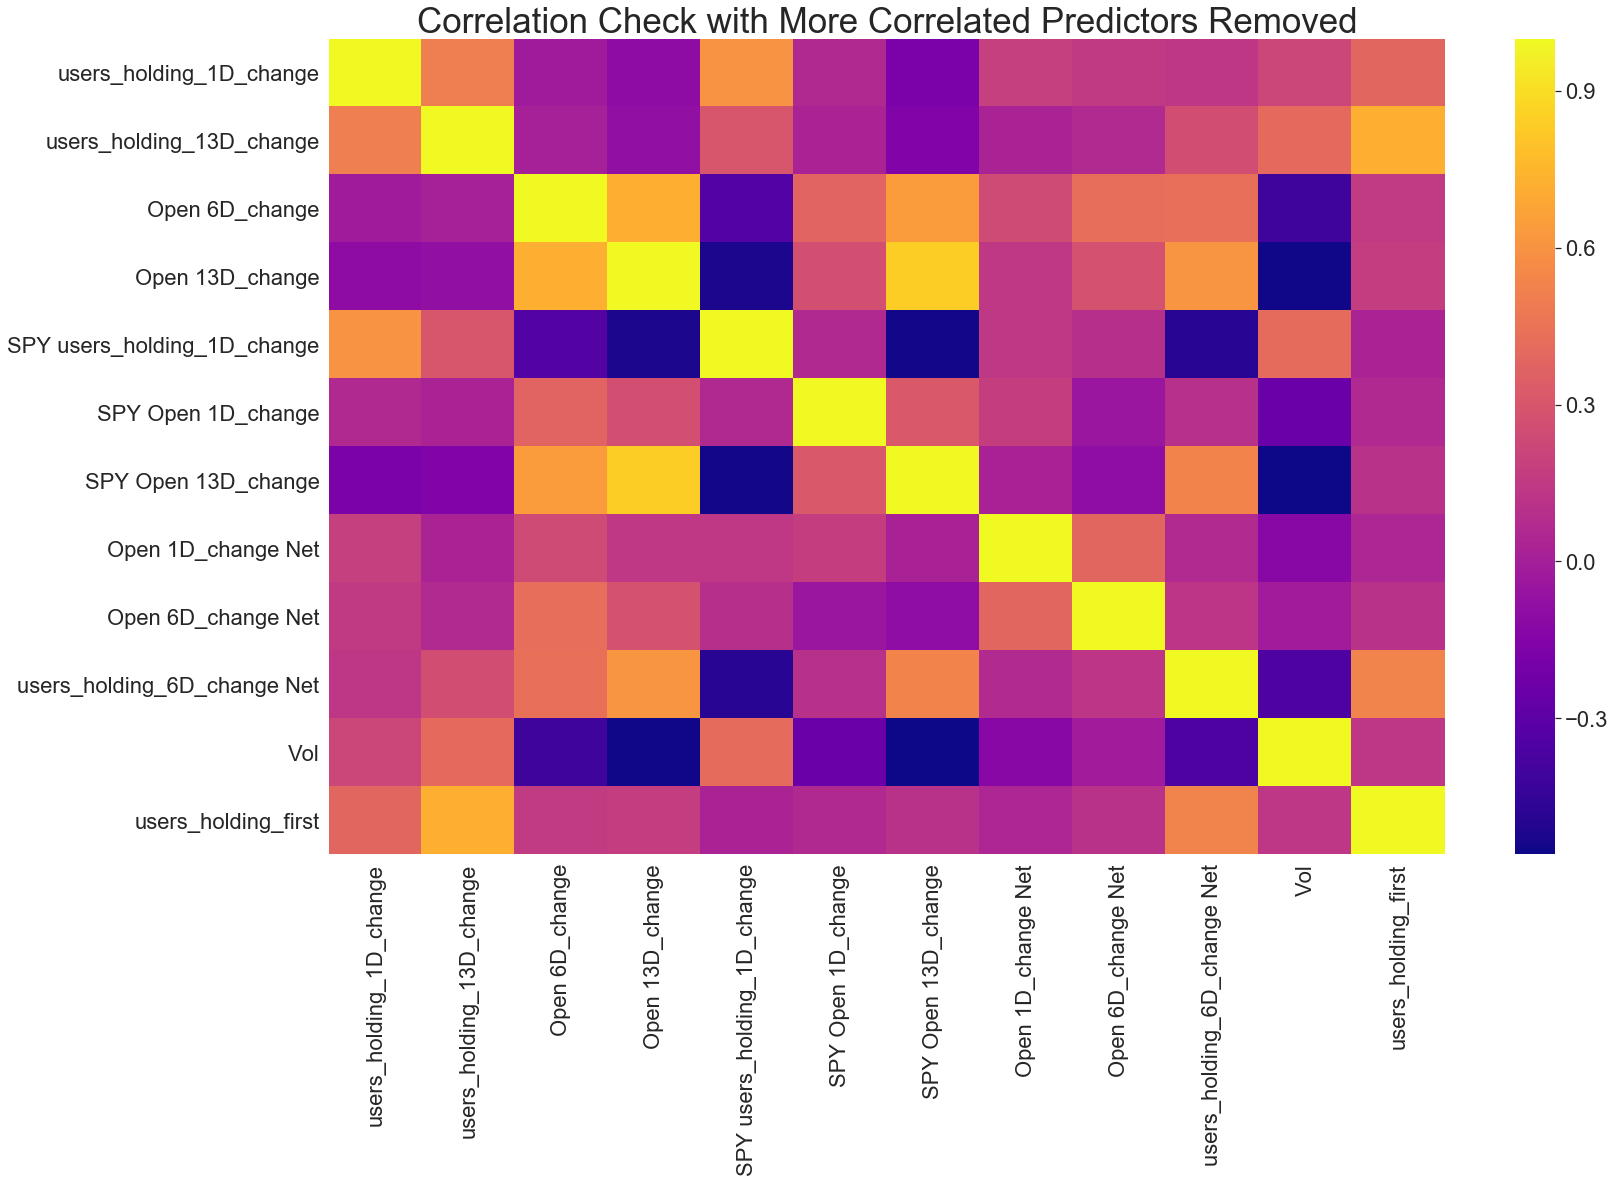

In [18]:
if is_fast_run:
    pass

else:

    #Let's try viz v4
    sns.set_context('paper')
    plt.figure(figsize = (25,15))
    sns.set(font_scale=2)
    sns.heatmap(df_apple_time_series_with_dropped_predictors.drop(['Target'], axis = 1).corr(), 
                annot = False, cmap = 'plasma').set_title('Correlation Check with More Correlated Predictors Removed', 
                                                          fontdict = {'fontsize':35});

    #Reset font scale for future graphs
    sns.set(font_scale=1)

We're going to drop `Open 13D_change` since it appears highly correlated with `Open 6D_change` and `SPY Open 13D_change`

In [19]:
#Review final list of predictors prior to creating model
if is_fast_run:
    pass

else:
    #Drop more correlated predictors
    columns = ['Open 13D_change']
    df_apple_time_series_with_dropped_predictors =\
        df_apple_time_series_with_dropped_predictors.drop(columns, axis = 1)
    
    #Preview predictors used in modeling exercise
    df_apple_time_series_with_dropped_predictors.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 182 entries, 2019-10-15 to 2020-07-16
Data columns (total 12 columns):
users_holding_1D_change        182 non-null float64
users_holding_13D_change       182 non-null float64
Open 6D_change                 182 non-null float64
SPY users_holding_1D_change    182 non-null float64
SPY Open 1D_change             182 non-null float64
SPY Open 13D_change            182 non-null float64
Open 1D_change Net             182 non-null float64
Open 6D_change Net             182 non-null float64
users_holding_6D_change Net    182 non-null float64
Target                         182 non-null float64
Vol                            182 non-null float64
users_holding_first            182 non-null float64
dtypes: float64(12)
memory usage: 18.5 KB


We are now ready to build our time series forecast! We'll be using the Facebook Prophet package since it is one of the more rigorous modeling packages available to use in Python today.

In [20]:
#Create train/test split from final modeling dataset
if is_fast_run:
    df_apple_final = pd.read_csv('Supplementary Files/df_apple_final.csv', 
                                 parse_dates= ['Clean_Datetime_PST', 'ds']).drop(['Clean_Datetime_PST'], axis =1)

else:
    df_apple_final = df_apple_time_series_with_dropped_predictors

    #Rename columns
    df_apple_final.rename(columns={'Target':'y'}, inplace=True)
    
    #Add datetime columns
    df_apple_final['ds'] = df_apple_final.index
    
#Train/test split
train = df_apple_final[:100]
test = df_apple_final[100:]

display(df_apple_final.head())
display(df_apple_final.info())

users_holding_1D_change  users_holding_13D_change  \
Clean_Datetime_PST                                                      
2019-10-15                           -0.002                    -0.031   
2019-10-16                            0.002                    -0.027   
2019-10-17                           -0.000                    -0.025   
2019-10-18                           -0.001                    -0.026   
2019-10-21                           -0.000                    -0.023   

                    Open 6D_change  SPY users_holding_1D_change  \
Clean_Datetime_PST                                                
2019-10-15                   0.041                       -0.003   
2019-10-16                   0.045                        0.001   
2019-10-17                   0.033                       -0.005   
2019-10-18                   0.036                        0.000   
2019-10-21                   0.029                       -0.001   

                    SPY Open 1D_change  SPY Open 13D_change  \
Clean_Datetime_PST                                            
2019-10-15                      -0.001               -0.000   
2019-10-16                       0.004               -0.002   
2019-10-17                       0.004                0.002   
2019-10-18                       0.004                0.013   
2019-10-21                      -0.003                0.003   

                    Open 1D_change Net  Open 6D_change Net  \
Clean_Datetime_PST                                           
2019-10-15                       0.009               0.025   
2019-10-16                       0.002               0.033   
2019-10-17                      -0.017               0.008   
2019-10-18                       0.003               0.005   
2019-10-21                       0.001               0.003   

                    users_holding_6D_change Net     y         Vol  \
Clean_Datetime_PST                                                  
2019-10-15                               -0.015  1.47  19492175.0   
2019-10-16                               -0.010 -3.00  16507440.0   
2019-10-17                                0.000  1.72  13244080.0   
2019-10-18                                0.003 -0.50  13136847.0   
2019-10-21                                0.005  2.90  16668237.0   

                    users_holding_first         ds  
Clean_Datetime_PST                                  
2019-10-15                     201954.0 2019-10-15  
2019-10-16                     202308.0 2019-10-16  
2019-10-17                     202288.0 2019-10-17  
2019-10-18                     202179.0 2019-10-18  
2019-10-21                     202121.0 2019-10-21

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 182 entries, 2019-10-15 to 2020-07-16
Data columns (total 13 columns):
users_holding_1D_change        182 non-null float64
users_holding_13D_change       182 non-null float64
Open 6D_change                 182 non-null float64
SPY users_holding_1D_change    182 non-null float64
SPY Open 1D_change             182 non-null float64
SPY Open 13D_change            182 non-null float64
Open 1D_change Net             182 non-null float64
Open 6D_change Net             182 non-null float64
users_holding_6D_change Net    182 non-null float64
y                              182 non-null float64
Vol                            182 non-null float64
users_holding_first            182 non-null float64
ds                             182 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(12)
memory usage: 19.9 KB


None

Here I iterate across each predictor in conjunction with the time data and target data to determine which model produces the highest accuracy. Aggregation calculations are performed for my accuracy metrics since multiple time horizon periods are reported for each built model.

This cell produces duplicate graphs for whatever reason, please ignore the repeats.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


'Plot for users_holding_1D_change'

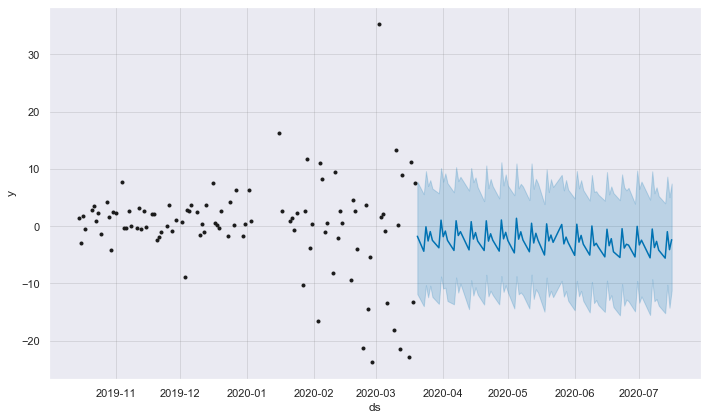

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-12-05 00:00:00 and 2020-02-23 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


'Plot for users_holding_13D_change'

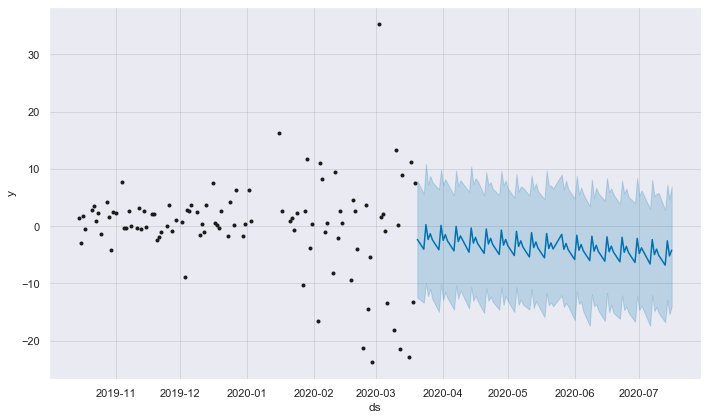

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-12-05 00:00:00 and 2020-02-23 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


'Plot for Open 6D_change'

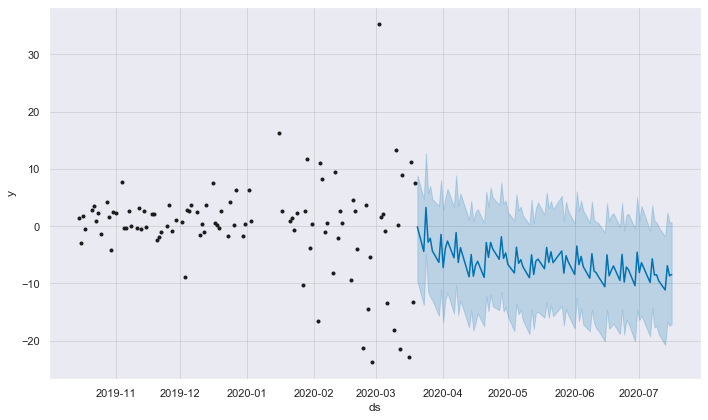

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-12-05 00:00:00 and 2020-02-23 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


'Plot for SPY users_holding_1D_change'

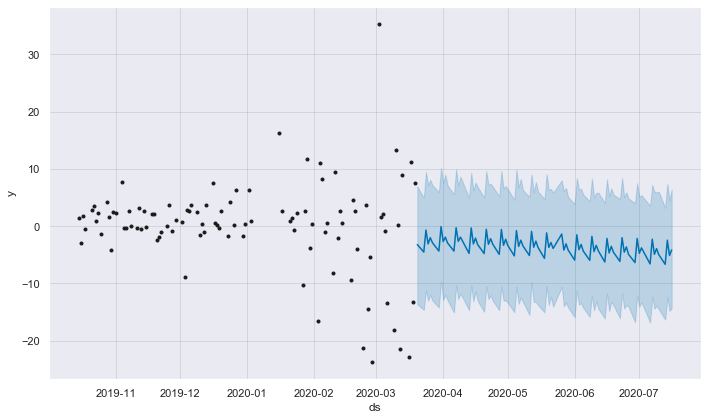

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-12-05 00:00:00 and 2020-02-23 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


'Plot for SPY Open 1D_change'

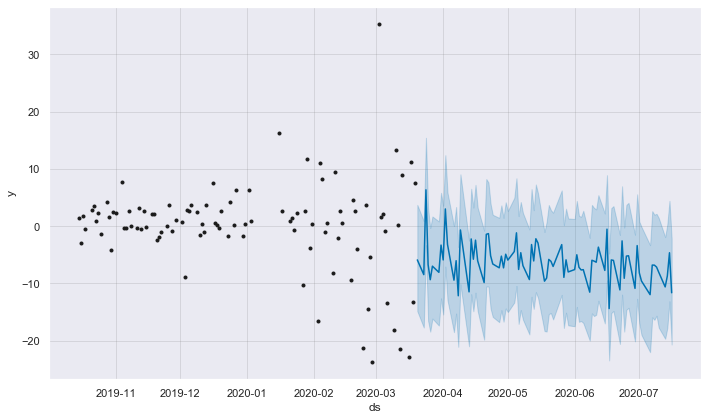

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-12-05 00:00:00 and 2020-02-23 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


'Plot for SPY Open 13D_change'

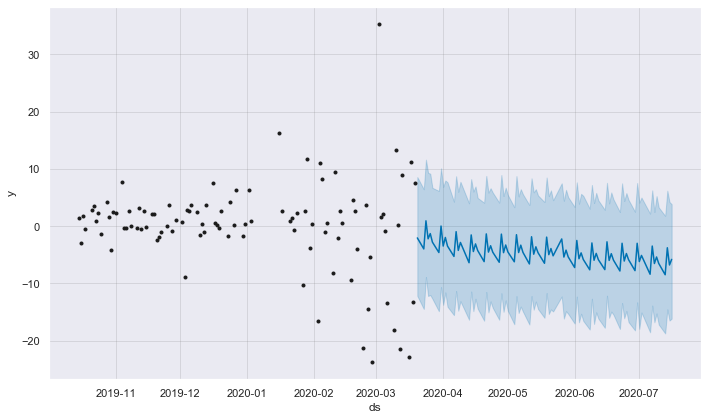

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-12-05 00:00:00 and 2020-02-23 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


'Plot for Open 1D_change Net'

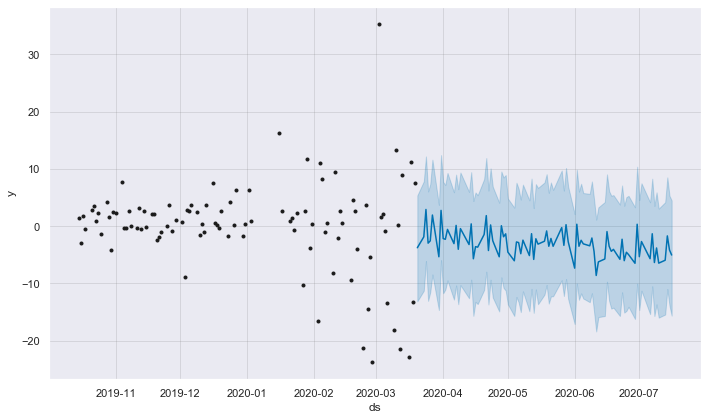

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-12-05 00:00:00 and 2020-02-23 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


'Plot for Open 6D_change Net'

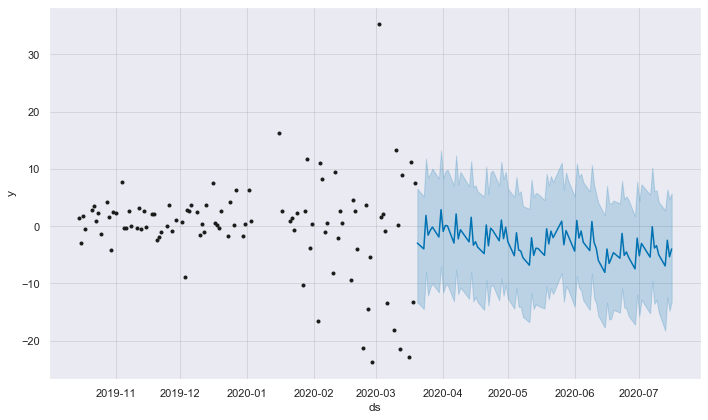

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-12-05 00:00:00 and 2020-02-23 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


'Plot for users_holding_6D_change Net'

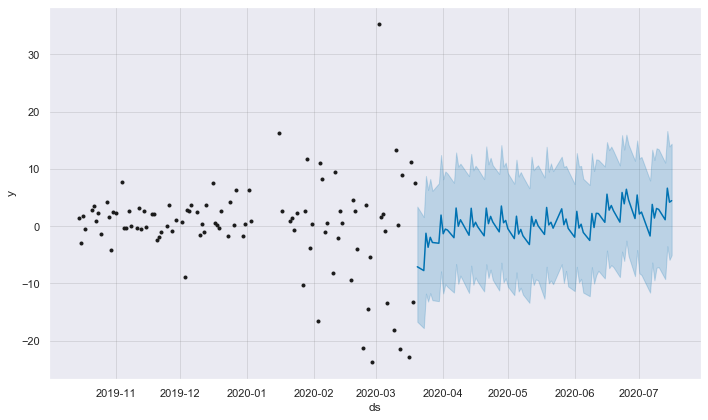

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-12-05 00:00:00 and 2020-02-23 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


'Plot for Vol'

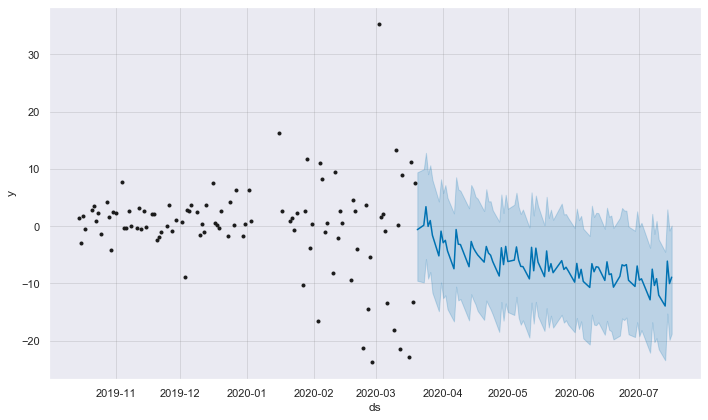

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-12-05 00:00:00 and 2020-02-23 00:00:00
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


'Plot for users_holding_first'

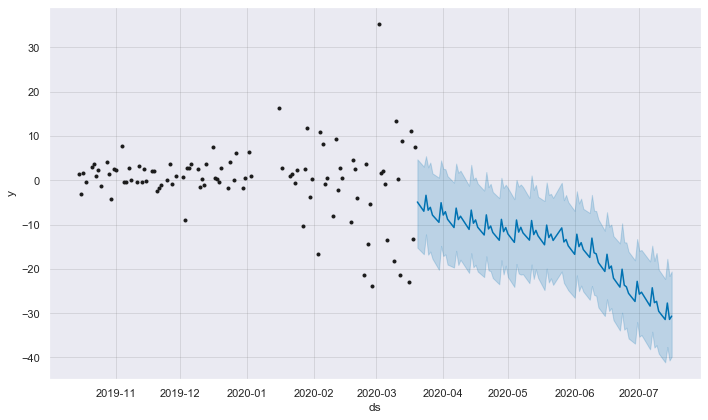

INFO:fbprophet:Making 5 forecasts with cutoffs between 2019-12-05 00:00:00 and 2020-02-23 00:00:00


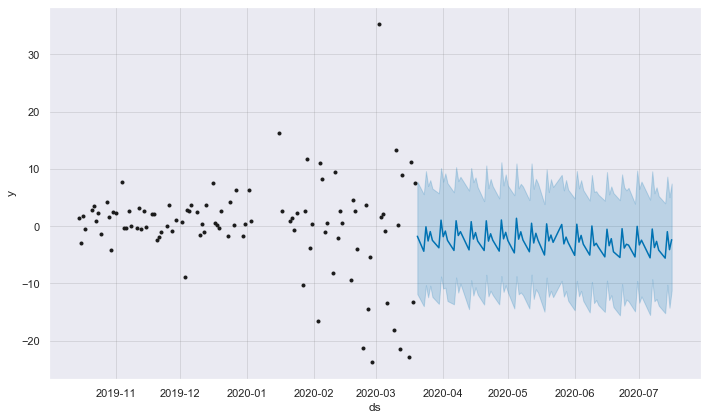

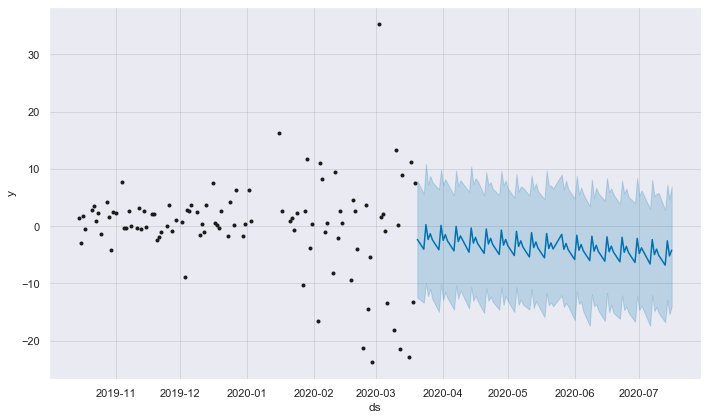

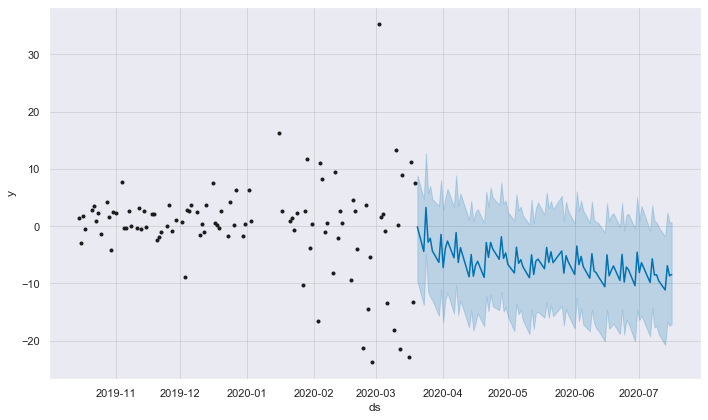

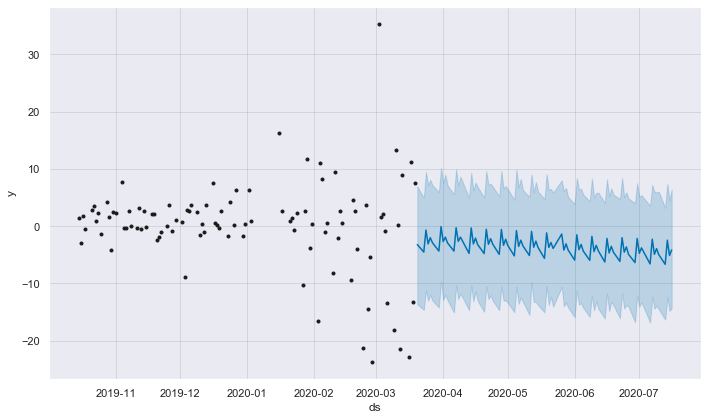

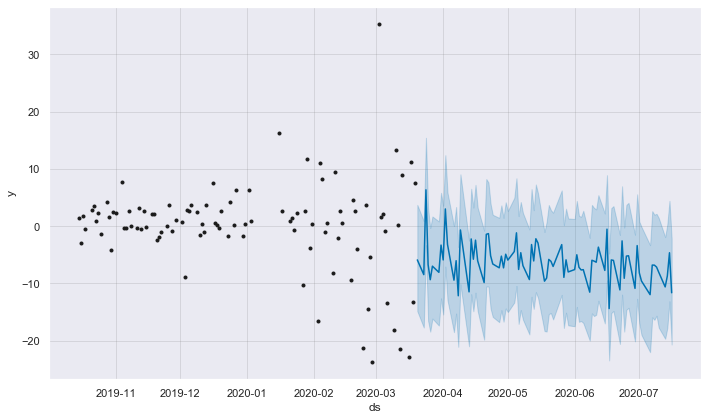

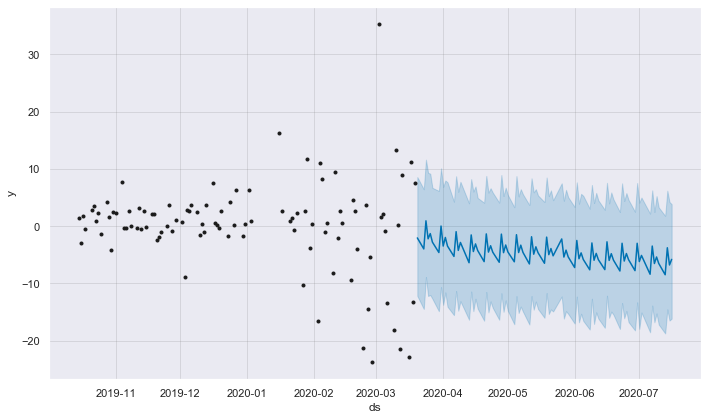

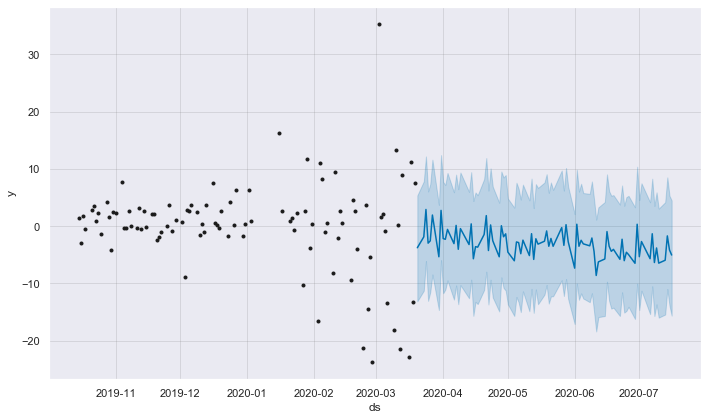

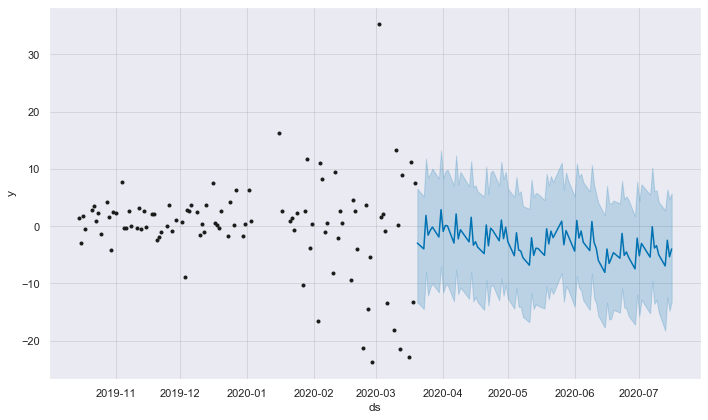

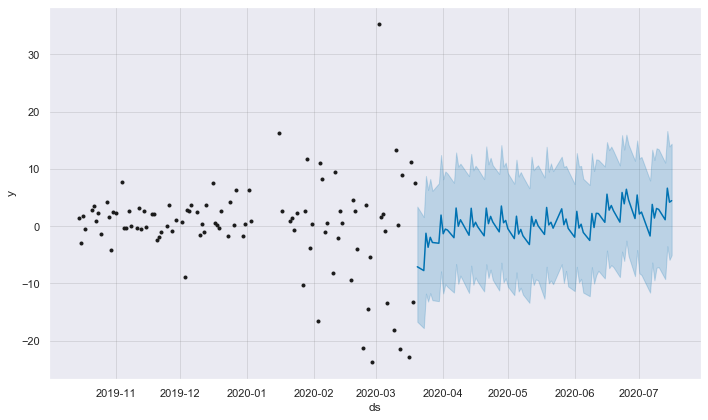

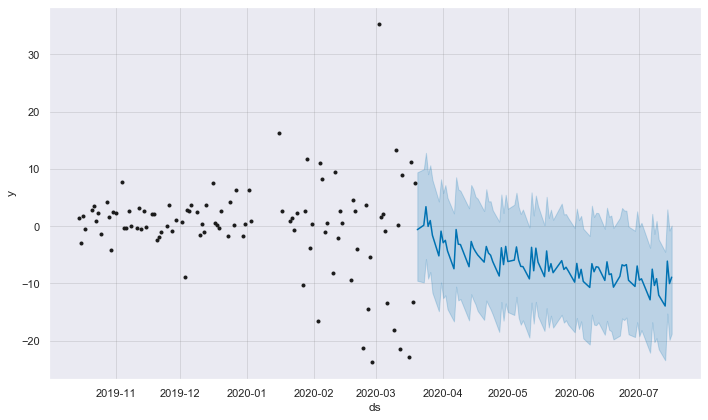

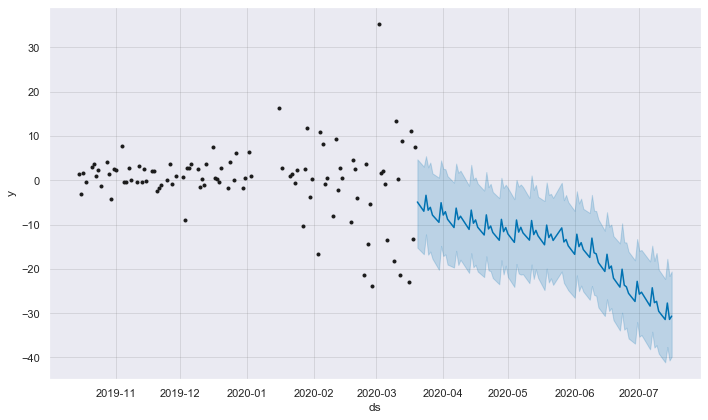

In [21]:
columns_list = train.columns
dictionary_of_performance = {}

for column in columns_list:
    apple_model_object = Prophet()
    
    if column in ['y', 'ds']:
        pass
    
    else:
        train_final = train[['y', 'ds', column]]
        test_final = test[['y', 'ds', column]]
        apple_model_object.add_regressor(column)
        
        #Fit the data
        apple_model_object.fit(train_final)
        future_data = apple_model_object.make_future_dataframe(periods=10)
        
        #Forecast the data for test data
        forecast_data = apple_model_object.predict(test_final)
        display(f'Plot for {column}')
        display(apple_model_object.plot(forecast_data))
        
        #Collect performance metrics
        df_cv = cross_validation(apple_model_object, initial = '50 days', period = '20 days', horizon = '25 days')
        df_performance_stats = performance_metrics(df_cv)
        df_performance_stats['horizon_int'] = df_performance_stats['horizon'].astype('str').str[:1]
        query = """
            Select
                horizon_int,
                avg(mse) as average_mse,
                avg(rmse) as average_rmse,
                avg(mae) as average_mae,
                avg(mape) as average_mape,
                avg(coverage) as average_coverage

            from df_performance_stats

            group by 1

                """

        dictionary_of_performance[column] = pysqldf(query)
    


Here I combine all my accuracy reporting into a single dataframe

In [22]:
# performance_metrics_columns = ['horizon', 'mse', 'rmse', 'mae', 'mape', 'coverage', 'regressor']
df_performance_metrics = pd.DataFrame()
for column in columns_list:
    if column in ['y', 'ds']:
        pass
    
    else:
        dictionary_of_performance[column]['regressor'] = column
        df_performance_metrics = df_performance_metrics.append(dictionary_of_performance[column][:11])
        
df_performance_metrics.head(20)

horizon_int  average_mse  average_rmse  average_mae  average_mape  \
0           1    48.961718      6.401238     4.779653      1.502629   
1           2   136.904349     11.565328     9.614171      1.760192   
2           3   117.368147     10.771092     9.195322      1.068809   
3           4    70.942774      8.374938     5.843915      1.099911   
4           5    70.314134      8.347947     5.495697      1.367625   
5           6    77.259264      8.789722     5.461053      1.782748   
6           7    77.741146      8.817043     5.549142      2.121941   
7           8   245.101675     15.654323     8.887552      1.831210   
8           9   131.236555      9.907832     6.043534      1.157071   
0           1    52.389803      6.699362     4.950293      1.640861   
1           2   140.488633     11.707103     9.678640      2.008459   
2           3   100.114857      9.923852     8.730759      1.111958   
3           4    52.300751      7.172306     4.958681      1.057875   
4           5    66.672279      8.019117     4.765028      1.197152   
5           6    83.008567      9.110903     5.313692      1.478325   
6           7    85.368179      9.239046     5.599711      1.800208   
7           8   233.142452     15.267616     8.565099      1.502919   
8           9   125.724681      9.796595     6.179515      1.291953   
0           1    50.136099      6.505832     4.832398      1.600073   
1           2   146.215716     11.951403     9.372784      1.723540   

   average_coverage                 regressor  
0          0.597884   users_holding_1D_change  
1          0.299320   users_holding_1D_change  
2          0.238095   users_holding_1D_change  
3          0.523810   users_holding_1D_change  
4          0.428571   users_holding_1D_change  
5          0.571429   users_holding_1D_change  
6          0.571429   users_holding_1D_change  
7          0.457143   users_holding_1D_change  
8          0.607143   users_holding_1D_change  
0          0.597884  users_holding_13D_change  
1          0.285714  users_holding_13D_change  
2          0.285714  users_holding_13D_change  
3          0.714286  users_holding_13D_change  
4          0.714286  users_holding_13D_change  
5          0.714286  users_holding_13D_change  
6          0.619048  users_holding_13D_change  
7          0.457143  users_holding_13D_change  
8          0.535714  users_holding_13D_change  
0          0.634921            Open 6D_change  
1          0.374150            Open 6D_change

I'm just going to compare 5 and 9 day time horizon intervals for my feature importance. Gathering that data here and performing some additional cleanup below.

In [23]:
df_performance_5_day = df_performance_metrics[df_performance_metrics['horizon_int'] == '5']
df_performance_9_day = df_performance_metrics[df_performance_metrics['horizon_int'] == '9']

display(df_performance_5_day.head())
display(df_performance_9_day.head())

horizon_int  average_mse  average_rmse  average_mae  average_mape  \
4           5    70.314134      8.347947     5.495697      1.367625   
4           5    66.672279      8.019117     4.765028      1.197152   
4           5   114.490867     10.548807     6.692442      1.519361   
4           5    73.581601      8.523342     5.847630      1.471352   
4           5    97.222559      9.655800     6.018444      1.207927   

   average_coverage                    regressor  
4          0.428571      users_holding_1D_change  
4          0.714286     users_holding_13D_change  
4          0.428571               Open 6D_change  
4          0.428571  SPY users_holding_1D_change  
4          0.571429           SPY Open 1D_change

horizon_int  average_mse  average_rmse  average_mae  average_mape  \
8           9   131.236555      9.907832     6.043534      1.157071   
8           9   125.724681      9.796595     6.179515      1.291953   
8           9    81.251898      8.118164     5.457655      1.146099   
8           9   120.685709      9.614003     5.899448      1.121983   
8           9    91.007262      8.698653     5.741685      1.397809   

   average_coverage                    regressor  
8          0.607143      users_holding_1D_change  
8          0.535714     users_holding_13D_change  
8          0.392857               Open 6D_change  
8          0.500000  SPY users_holding_1D_change  
8          0.535714           SPY Open 1D_change

In [24]:
#Combine dataframes
df_performance_for_graph = pd.concat([df_performance_5_day, df_performance_9_day])

#Reduce dataframe down to key components you're most interested in
df_performance_for_graph = df_performance_for_graph[['horizon_int', 'average_rmse', 'regressor']]

#Rename a column (for my graph)
df_performance_for_graph.rename(columns={'horizon_int':'Time Horizon Predicted (Days)'}, inplace=True)

#Preview dataframe
df_performance_for_graph.head(30)

Time Horizon Predicted (Days)  average_rmse                    regressor
4                             5      8.347947      users_holding_1D_change
4                             5      8.019117     users_holding_13D_change
4                             5     10.548807               Open 6D_change
4                             5      8.523342  SPY users_holding_1D_change
4                             5      9.655800           SPY Open 1D_change
4                             5     10.810726          SPY Open 13D_change
4                             5      8.753518           Open 1D_change Net
4                             5      9.477332           Open 6D_change Net
4                             5      9.377268  users_holding_6D_change Net
4                             5      9.020992                          Vol
4                             5      8.610978          users_holding_first
8                             9      9.907832      users_holding_1D_change
8                             9      9.796595     users_holding_13D_change
8                             9      8.118164               Open 6D_change
8                             9      9.614003  SPY users_holding_1D_change
8                             9      8.698653           SPY Open 1D_change
8                             9      8.146086          SPY Open 13D_change
8                             9      9.645745           Open 1D_change Net
8                             9      9.125551           Open 6D_change Net
8                             9      9.181674  users_holding_6D_change Net
8                             9      8.970685                          Vol
8                             9      9.538546          users_holding_first

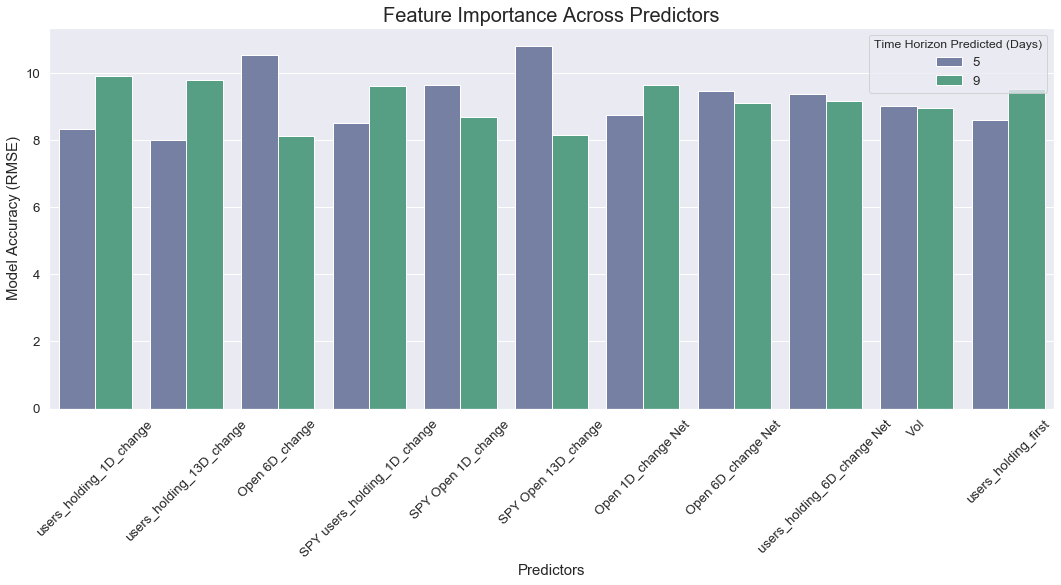

In [25]:
#Publish graph of feature importance
plt.figure(figsize = (18,7))
sns.set(font_scale=1.2)
sns.barplot(x = 'regressor', y = 'average_rmse', data=df_performance_for_graph, 
            hue= 'Time Horizon Predicted (Days)', 
            palette = ['#6e7ca9', '#4aab88']).\
            set_title('Feature Importance Across Predictors', fontsize = 20)
plt.xlabel('Predictors', fontsize= 15)
plt.ylabel('Model Accuracy (RMSE)', fontsize= 15)
plt.xticks(rotation = 45);